#Supervised Contrastive Learning

[Supervised Contrastive Learning](https://arxiv.org/abs/2004.11362)
(Prannay Khosla et al.) is a training methodology that outperforms
supervised training with crossentropy on classification tasks.

Essentially, training an image classification model with Supervised Contrastive
Learning is performed in two phases:

1. Training an encoder to learn to produce vector representations of input images such
that representations of images in the same class will be more similar compared to
representations of images in different classes.
2. Training a classifier on top of the frozen encoder.

Implementation by G. M. Shahariar Shibli

#Version and GPU check

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.11.0


In [ ]:
!nvidia-smi

Wed Mar 22 02:34:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    27W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Installation

In [ ]:
%%capture
!pip3 install tensorflow-addons
!pip3 install tf_keras_vis

#Imports

In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow import keras

import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import numpy as np
import cv2
import datetime
import glob
import os

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

#Configurations

In [ ]:
BATCH_SIZE = 64
EPOCHS = 50
CROP_TO = 224

num_classes = 23
input_shape = (224, 224, 3)

LR = 2e-5
shuffler = 1024

#Data Augmentation

In [ ]:
def flip_random_crop(image):
    # With random crops we also apply horizontal flipping.
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_crop(image, (CROP_TO, CROP_TO, 3))
    return image

def color_jitter(x, strength=[0.4, 0.4, 0.4, 0.1]):
    x = tf.image.random_brightness(x, max_delta=0.8 * strength[0])
    x = tf.image.random_contrast(
        x, lower=1 - 0.8 * strength[1], upper=1 + 0.8 * strength[1]
    )
    x = tf.image.random_saturation(
        x, lower=1 - 0.8 * strength[2], upper=1 + 0.8 * strength[2]
    )
    x = tf.image.random_hue(x, max_delta=0.2 * strength[3])
    # Affine transformations can disturb the natural range of
    # RGB images, hence this is needed.
    x = tf.clip_by_value(x, 0, 255)
    return x

def color_drop(x):
    x = tf.image.rgb_to_grayscale(x)
    x = tf.tile(x, [1, 1, 3])
    return x


def random_apply(func, x, p):
    if tf.random.uniform([], minval=0, maxval=1) < p:
        return func(x)
    else:
        return x


def custom_augment(image, label):
    # As discussed in the SimCLR paper, the series of augmentation
    # transformations (except for random crops) need to be applied
    # randomly to impose translational invariance.
    image = flip_random_crop(image)
    image = random_apply(color_jitter, image, p=0.8)
    image = random_apply(color_drop, image, p=0.2)
    return image, label

# Data Processing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cecum = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/cecum/*.*')
ileum = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/ileum/*.*')
retroflex_rectum = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/retroflex_rectum/*.*')
hemorrhoids = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/hemorrhoids/*.*')
polyps = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/polyps/*.*')
ulcerative_colitis_grade_0_1 = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/ulcerative-colitis-grade-0-1/*.*')
ulcerative_colitis_grade_1 = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/ulcerative-colitis-grade-1/*.*')
ulcerative_colitis_grade_1_2 = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/ulcerative-colitis-grade-1-2/*.*')
ulcerative_colitis_grade_2 = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/ulcerative-colitis-grade-2/*.*')
ulcerative_colitis_grade_2_3 = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/ulcerative-colitis-grade-2-3/*.*')
ulcerative_colitis_grade_3 = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/ulcerative-colitis-grade-3/*.*')
bbps_0_1 = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/bbps-0-1/*.*')
bbps_2_3 = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/bbps-2-3/*.*')
impacted_stool = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/impacted-stool/*.*')
dyed_lifted_polyps = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/dyed-lifted-polyps/*.*')
dyed_resection_margins = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/dyed-resection-margins/*.*')
pylorus = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/pylorus/*.*')
retroflex_stomach = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/retroflex_stomach/*.*')
z_line = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/z_line/*.*')
barretts = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/barretts/*.*')
barretts_short_segment = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/barretts-short-segment/*.*')
esophagitis_a = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/esophagitis-a/*.*')
esophagitis_b_d = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/esophagitis-b-d/*.*')

In [ ]:
dataset = {0 :cecum, 1:ileum, 2:retroflex_rectum, 3:hemorrhoids, 4:polyps,5:ulcerative_colitis_grade_0_1,6:ulcerative_colitis_grade_1,7:ulcerative_colitis_grade_1_2,8:ulcerative_colitis_grade_2,9:ulcerative_colitis_grade_2_3,10:ulcerative_colitis_grade_3,11:bbps_0_1 ,12:bbps_2_3,13:impacted_stool,14:dyed_lifted_polyps,15:dyed_resection_margins,16:pylorus,17:retroflex_stomach,18:z_line,19:barretts,20:barretts_short_segment,21:esophagitis_a ,22:esophagitis_b_d }

In [ ]:
def combineDataAndLabel(width, height, dataset):

  data = []
  labels = []
  count = 0

  for cls in dataset:
      print(f"\n\nconverting {cls} \n\n")
      for i in dataset[cls]:
          print(f"\nconverting image:  {i}")
          image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb',
          target_size= (width,height))
          image=np.array(image)
          data.append(image)
          count=count+1
          labels.append(cls)
      print(f"\n\processed {count} images \n\n")


  # for i in cecum:
  #     image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb',
  #     target_size= (width,height))
  #     image=np.array(image)
  #     data.append(image)
  #     labels.append(0)

  # for i in ileum:
  #     image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb',
  #     target_size= (width,height))
  #     image=np.array(image)
  #     data.append(image)
  #     labels.append(1)
  # for i in pylorus:
  #     image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb',
  #     target_size= (width,height))
  #     image=np.array(image)
  #     data.append(image)
  #     labels.append(2)
  # for i in retroflex_rectum:
  #     image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb',
  #     target_size= (width,height))
  #     image=np.array(image)
  #     data.append(image)
  #     labels.append(3)
  # for i in retroflex_stomach:
  #     image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb',
  #     target_size= (width,height))
  #     image=np.array(image)
  #     data.append(image)
  #     labels.append(4)
  # for i in z_line:
  #     image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb',
  #     target_size= (width,height))
  #     image=np.array(image)
  #     data.append(image)
  #     labels.append(5)

  data = np.array(data)
  labels = np.array(labels)

  print(f"\n\nSaving to drive\n\n")
  np.save('/content/drive/MyDrive/ML/combinedData_224', data)
  np.save('/content/drive/MyDrive/ML/combinedLabels_224', labels)
  print(f"\n\nSaved")

  return data, labels


In [ ]:
import os
data = []
labels = []
if(os.path.isfile("/content/drive/MyDrive/ML/combinedData_224.npy") and os.path.isfile("/content/drive/MyDrive/ML/combinedLabels_224.npy")):
  data = np.load("/content/drive/MyDrive/ML/combinedData_224.npy")
  labels = np.load("/content/drive/MyDrive/ML/combinedLabels_224.npy")
else:
  data, labels = combineDataAndLabel(224,224,dataset)


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2,
                                                random_state=42,stratify = labels)

In [ ]:
# Load data
#(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Display shapes of train and test datasets
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


x_train shape: (8529, 224, 224, 3) - y_train shape: (8529,)
x_test shape: (2133, 224, 224, 3) - y_test shape: (2133,)


In [ ]:
#contrastive training
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = (train_ds.shuffle(shuffler).map(custom_augment).batch(BATCH_SIZE))

#cross-entropy training
train_ds2 = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(shuffler).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).shuffle(shuffler).batch(BATCH_SIZE)

#Contrastive Loss Functions

Max Margin Loss, N pairs loss, Triplet loss, NT-XENT loss

In [ ]:
def pdist_euclidean(A):
    # Euclidean pdist
    # https://stackoverflow.com/questions/37009647/compute-pairwise-distance-in-a-batch-without-replicating-tensor-in-tensorflow
    r = tf.reduce_sum(A*A, 1)

    # turn r into column vector
    r = tf.reshape(r, [-1, 1])
    D = r - 2*tf.matmul(A, tf.transpose(A)) + tf.transpose(r)
    return tf.sqrt(D)


#def square_to_vec(D):
   #'''Convert a squared form pdist matrix to vector form.
    #'''
 #   n = D.shape[0]
  #  triu_idx = np.triu_indices(n, k=1)
   # d_vec = tf.gather_nd(D, list(zip(triu_idx[0], triu_idx[1])))
    #return d_vec
def square_to_vec(D):
    with tf.name_scope("square_to_vec"):
        n = D.shape[0]
        triu_idx = np.triu_indices(n, k=1)
        triu_idx_int = np.array(triu_idx).astype(np.int32)
        d_vec = tf.gather_nd(D, list(zip(triu_idx_int[0], triu_idx_int[1])))
        return d_vec


def get_contrast_batch_labels(y):
    '''
    Make contrast labels by taking all the pairwise in y
    y: tensor with shape: (batch_size, )
    returns:
        tensor with shape: (batch_size * (batch_size-1) // 2, )
    '''
    y_col_vec = tf.reshape(tf.cast(y, tf.float32), [-1, 1])
    D_y = pdist_euclidean(y_col_vec)
    d_y = square_to_vec(D_y)
    y_contrasts = tf.cast(d_y == 0, tf.int32)
    return y_contrasts


def get_contrast_batch_labels_regression(y):
    '''
    Make contrast labels for regression by taking all the pairwise in y
    y: tensor with shape: (batch_size, )
    returns:
        tensor with shape: (batch_size * (batch_size-1) // 2, )
    '''
    raise NotImplementedError


def max_margin_contrastive_loss(z, y, margin=1.0, metric='euclidean'):
    '''
    Wrapper for the maximum margin contrastive loss (Hadsell et al. 2006)
    `tfa.losses.contrastive_loss`
    Args:
        z: hidden vector of shape [bsz, n_features].
        y: ground truth of shape [bsz].
        metric: one of ('euclidean', 'cosine')
    '''
    # compute pair-wise distance matrix
    if metric == 'euclidean':
        D = pdist_euclidean(z)
    elif metric == 'cosine':
        D = 1 - tf.matmul(z, z, transpose_a=False, transpose_b=True)
    # convert squareform matrix to vector form
    d_vec = square_to_vec(D)
    # make contrastive labels
    y_contrasts = get_contrast_batch_labels(y)
    loss = tfa.losses.contrastive_loss(y_contrasts, d_vec, margin=margin)
    # exploding/varnishing gradients on large batch?
    return tf.reduce_mean(loss)


def multiclass_npairs_loss(z, y):
    '''
    Wrapper for the multiclass N-pair loss (Sohn 2016)
    `tfa.losses.npairs_loss`
    Args:
        z: hidden vector of shape [bsz, n_features].
        y: ground truth of shape [bsz].
    '''
    # cosine similarity matrix
    S = tf.matmul(z, z, transpose_a=False, transpose_b=True)
    loss = tfa.losses.npairs_loss(y, S)
    return loss


def triplet_loss(z, y, margin=1.0, kind='hard'):
    '''
    Wrapper for the triplet losses
    `tfa.losses.triplet_hard_loss` and `tfa.losses.triplet_semihard_loss`
    Args:
        z: hidden vector of shape [bsz, n_features], assumes it is l2-normalized.
        y: ground truth of shape [bsz].
    '''
    if kind == 'hard':
        loss = tfa.losses.triplet_hard_loss(y, z, margin=margin, soft=False)
    elif kind == 'soft':
        loss = tfa.losses.triplet_hard_loss(y, z, margin=margin, soft=True)
    elif kind == 'semihard':
        loss = tfa.losses.triplet_semihard_loss(y, z, margin=margin)
    return loss


def supervised_nt_xent_loss(z, y, temperature=0.5, base_temperature=0.07):
    '''
    Supervised normalized temperature-scaled cross entropy loss.
    A variant of Multi-class N-pair Loss from (Sohn 2016)
    Later used in SimCLR (Chen et al. 2020, Khosla et al. 2020).
    Implementation modified from:
        - https://github.com/google-research/simclr/blob/master/objective.py
        - https://github.com/HobbitLong/SupContrast/blob/master/losses.py
    Args:
        z: hidden vector of shape [bsz, n_features].
        y: ground truth of shape [bsz].
    '''
    batch_size = tf.shape(z)[0]
    contrast_count = 1
    anchor_count = contrast_count
    y = tf.expand_dims(y, -1)

    # mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
    #     has the same class as sample i. Can be asymmetric.
    mask = tf.cast(tf.equal(y, tf.transpose(y)), tf.float32)
    anchor_dot_contrast = tf.divide(
        tf.matmul(z, tf.transpose(z)),
        temperature
    )
    # # for numerical stability
    logits_max = tf.reduce_max(anchor_dot_contrast, axis=1, keepdims=True)
    logits = anchor_dot_contrast - logits_max
    # # tile mask
    logits_mask = tf.ones_like(mask) - tf.eye(batch_size)
    mask = mask * logits_mask
    # compute log_prob
    exp_logits = tf.exp(logits) * logits_mask
    log_prob = logits - \
        tf.math.log(tf.reduce_sum(exp_logits, axis=1, keepdims=True))

    # compute mean of log-likelihood over positive
    # this may introduce NaNs due to zero division,
    # when a class only has one example in the batch
    mask_sum = tf.reduce_sum(mask, axis=1)
    mean_log_prob_pos = tf.reduce_sum(
        mask * log_prob, axis=1)[mask_sum > 0] / mask_sum[mask_sum > 0]

    # loss
    loss = -(temperature / base_temperature) * mean_log_prob_pos
    # loss = tf.reduce_mean(tf.reshape(loss, [anchor_count, batch_size]))
    loss = tf.reduce_mean(loss)
    return loss

#Encoder with Contrastive Learning

In [ ]:
#Layer Batch Normalization
class UnitNormLayer(tf.keras.layers.Layer):
    '''Normalize vectors (euclidean norm) in batch to unit hypersphere.
    '''

    def __init__(self):
        super(UnitNormLayer, self).__init__()

    def call(self, input_tensor):
        norm = tf.norm(input_tensor, axis=1)
        return input_tensor / tf.reshape(norm, [-1, 1])

In [ ]:
# Encoder Architecture
def get_resnet_simclr(hidden_1, hidden_2, hidden_3):
    base_model = tf.keras.applications.DenseNet121(include_top=False, weights=None, input_shape=input_shape)
    base_model.trainable = True
    h = base_model.output
    h = GlobalAveragePooling2D()(h)

    projection_1 = Dense(hidden_1)(h)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)
    projection_2 = Activation("relu")(projection_2)
    projection_3 = Dense(hidden_3)(projection_2)

    normalized_embed = UnitNormLayer()(projection_3)

    resnet_simclr = Model(base_model.inputs, normalized_embed)

    return resnet_simclr

In [ ]:
encoder_optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
model = get_resnet_simclr(512, 256, 128)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [ ]:
train_loss_cl = tf.keras.metrics.Mean(name='train_loss')
test_loss_cl = tf.keras.metrics.Mean(name='test_loss')

In [ ]:
@tf.function

def train_step_contrastive(x, y):
    '''
    x: data tensor, shape: (batch_size, data_dim)
    y: data labels, shape: (batch_size, )
    '''
    with tf.GradientTape() as tape:
        r = model(x, training=True)
        loss = max_margin_contrastive_loss(r, y, margin=1.0, metric='euclidean')

    gradients = tape.gradient(loss, model.trainable_variables)
    encoder_optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss_cl(loss)

In [ ]:
@tf.function
def test_step_contrastive(x, y):
    r = model(x, training=False)
    t_loss = max_margin_contrastive_loss(r, y, margin=1.0, metric='euclidean')
    test_loss_cl(t_loss)

In [ ]:
#Encoder training
train_loss_dict = {}
test_loss_dict = {}

for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss_cl.reset_states()
    test_loss_cl.reset_states()

    for x, y in tqdm(train_ds):
        train_step_contrastive(x, y)

    for x_te, y_te in test_ds:
        test_step_contrastive(x_te, y_te)

    template = 'Epoch {}, Training Loss: {}, Test Loss: {}'
    print(template.format(epoch + 1,train_loss_cl.result(),test_loss_cl.result()))
    train_loss_dict[epoch] = train_loss_cl.result().numpy()*100
    test_loss_dict[epoch] = test_loss_cl.result().numpy()*100

100%|██████████| 134/134 [03:04<00:00,  1.37s/it]


Epoch 1, Training Loss: 0.07975113391876221, Test Loss: 0.2122279554605484


100%|██████████| 134/134 [01:27<00:00,  1.53it/s]


Epoch 2, Training Loss: 0.062141865491867065, Test Loss: 0.06821919977664948


100%|██████████| 134/134 [01:27<00:00,  1.54it/s]


Epoch 3, Training Loss: 0.05865524336695671, Test Loss: 0.04813616722822189


100%|██████████| 134/134 [01:27<00:00,  1.53it/s]


Epoch 4, Training Loss: 0.05602037534117699, Test Loss: 0.04586140811443329


100%|██████████| 134/134 [01:27<00:00,  1.54it/s]


Epoch 5, Training Loss: 0.05425345525145531, Test Loss: 0.04380514472723007


100%|██████████| 134/134 [01:27<00:00,  1.54it/s]


Epoch 6, Training Loss: 0.05204955115914345, Test Loss: 0.04177890345454216


100%|██████████| 134/134 [01:27<00:00,  1.54it/s]


Epoch 7, Training Loss: 0.050517551600933075, Test Loss: 0.043723173439502716


100%|██████████| 134/134 [01:27<00:00,  1.53it/s]


Epoch 8, Training Loss: 0.04940030351281166, Test Loss: 0.03889619559049606


100%|██████████| 134/134 [01:27<00:00,  1.54it/s]


Epoch 9, Training Loss: 0.04882815107703209, Test Loss: 0.040278203785419464


100%|██████████| 134/134 [01:27<00:00,  1.54it/s]


Epoch 10, Training Loss: 0.047106239944696426, Test Loss: 0.03599720075726509


100%|██████████| 134/134 [01:27<00:00,  1.54it/s]


Epoch 11, Training Loss: 0.046169720590114594, Test Loss: 0.03557899221777916


100%|██████████| 134/134 [01:27<00:00,  1.53it/s]


Epoch 12, Training Loss: 0.04541758820414543, Test Loss: 0.032997436821460724


100%|██████████| 134/134 [01:27<00:00,  1.53it/s]


Epoch 13, Training Loss: 0.042763061821460724, Test Loss: 0.03425033763051033


100%|██████████| 134/134 [01:27<00:00,  1.54it/s]


Epoch 14, Training Loss: 0.04315952584147453, Test Loss: 0.03349051997065544


100%|██████████| 134/134 [01:27<00:00,  1.54it/s]


Epoch 15, Training Loss: 0.04260630160570145, Test Loss: 0.037022173404693604


100%|██████████| 134/134 [01:27<00:00,  1.54it/s]


Epoch 16, Training Loss: 0.041866373270750046, Test Loss: 0.031948238611221313


100%|██████████| 134/134 [02:21<00:00,  1.06s/it]


Epoch 17, Training Loss: 0.04042241349816322, Test Loss: 0.029843119904398918


100%|██████████| 134/134 [01:27<00:00,  1.53it/s]


Epoch 18, Training Loss: 0.039818182587623596, Test Loss: 0.03468198701739311


100%|██████████| 134/134 [01:27<00:00,  1.54it/s]


Epoch 19, Training Loss: 0.039066195487976074, Test Loss: 0.02965807169675827


100%|██████████| 134/134 [01:27<00:00,  1.54it/s]


Epoch 20, Training Loss: 0.03740904480218887, Test Loss: 0.031437862664461136


100%|██████████| 134/134 [01:27<00:00,  1.54it/s]


Epoch 21, Training Loss: 0.03721527382731438, Test Loss: 0.030444545671343803


100%|██████████| 134/134 [01:27<00:00,  1.54it/s]


Epoch 22, Training Loss: 0.03632885590195656, Test Loss: 0.028264010325074196


100%|██████████| 134/134 [01:27<00:00,  1.53it/s]


Epoch 23, Training Loss: 0.036508958786726, Test Loss: 0.02833254635334015


100%|██████████| 134/134 [01:27<00:00,  1.54it/s]


Epoch 24, Training Loss: 0.03511452674865723, Test Loss: 0.028212567791342735


100%|██████████| 134/134 [01:27<00:00,  1.54it/s]


Epoch 25, Training Loss: 0.034749943763017654, Test Loss: 0.02785247191786766


100%|██████████| 134/134 [01:27<00:00,  1.54it/s]


Epoch 26, Training Loss: 0.033944591879844666, Test Loss: 0.026614977046847343


100%|██████████| 134/134 [01:27<00:00,  1.54it/s]


Epoch 27, Training Loss: 0.0344017893075943, Test Loss: 0.028000282123684883


100%|██████████| 134/134 [01:27<00:00,  1.53it/s]


Epoch 28, Training Loss: 0.03322015330195427, Test Loss: 0.027827393263578415


100%|██████████| 134/134 [01:27<00:00,  1.53it/s]


Epoch 29, Training Loss: 0.03263140097260475, Test Loss: 0.025109458714723587


100%|██████████| 134/134 [01:27<00:00,  1.53it/s]


Epoch 30, Training Loss: 0.0327511690557003, Test Loss: 0.02726905234158039


100%|██████████| 134/134 [01:27<00:00,  1.53it/s]


Epoch 31, Training Loss: 0.032007720321416855, Test Loss: 0.026585979387164116


100%|██████████| 134/134 [01:27<00:00,  1.53it/s]


Epoch 32, Training Loss: 0.031184649094939232, Test Loss: 0.024095073342323303


100%|██████████| 134/134 [01:27<00:00,  1.53it/s]


Epoch 33, Training Loss: 0.03147827461361885, Test Loss: 0.02332882583141327


100%|██████████| 134/134 [01:27<00:00,  1.54it/s]


Epoch 34, Training Loss: 0.03000984899699688, Test Loss: 0.026562398299574852


100%|██████████| 134/134 [01:27<00:00,  1.54it/s]


Epoch 35, Training Loss: 0.03004995360970497, Test Loss: 0.02730235457420349


100%|██████████| 134/134 [01:27<00:00,  1.54it/s]


Epoch 36, Training Loss: 0.029778100550174713, Test Loss: 0.026685260236263275


100%|██████████| 134/134 [01:27<00:00,  1.54it/s]


Epoch 37, Training Loss: 0.029244136065244675, Test Loss: 0.02363716810941696


100%|██████████| 134/134 [01:27<00:00,  1.54it/s]


Epoch 38, Training Loss: 0.02933165803551674, Test Loss: 0.025567904114723206


100%|██████████| 134/134 [01:27<00:00,  1.54it/s]


Epoch 39, Training Loss: 0.02915133535861969, Test Loss: 0.026050852611660957


100%|██████████| 134/134 [01:27<00:00,  1.54it/s]


Epoch 40, Training Loss: 0.028067568317055702, Test Loss: 0.023730918765068054


100%|██████████| 134/134 [01:27<00:00,  1.54it/s]


Epoch 41, Training Loss: 0.028252890333533287, Test Loss: 0.02296929620206356


100%|██████████| 134/134 [01:27<00:00,  1.54it/s]


Epoch 42, Training Loss: 0.02741042524576187, Test Loss: 0.02382883056998253


100%|██████████| 134/134 [01:27<00:00,  1.53it/s]


Epoch 43, Training Loss: 0.02775304950773716, Test Loss: 0.02187398448586464


100%|██████████| 134/134 [01:27<00:00,  1.53it/s]


Epoch 44, Training Loss: 0.02748950570821762, Test Loss: 0.023205772042274475


100%|██████████| 134/134 [01:27<00:00,  1.53it/s]


Epoch 45, Training Loss: 0.027397090569138527, Test Loss: 0.022795580327510834


100%|██████████| 134/134 [01:27<00:00,  1.54it/s]


Epoch 46, Training Loss: 0.026619600132107735, Test Loss: 0.021329373121261597


100%|██████████| 134/134 [01:27<00:00,  1.53it/s]


Epoch 47, Training Loss: 0.026427187025547028, Test Loss: 0.022088222205638885


100%|██████████| 134/134 [01:27<00:00,  1.54it/s]


Epoch 48, Training Loss: 0.026351507753133774, Test Loss: 0.02598480135202408


100%|██████████| 134/134 [01:27<00:00,  1.54it/s]


Epoch 49, Training Loss: 0.02607881650328636, Test Loss: 0.022301360964775085


100%|██████████| 134/134 [01:27<00:00,  1.53it/s]


Epoch 50, Training Loss: 0.025755086913704872, Test Loss: 0.03369307890534401


In [ ]:
from pickle import load, dump
from matplotlib.pylab import plt
from numpy import arange

In [ ]:
# Save the training loss values
with open('/content/drive/MyDrive/ML/train_loss_DenseNet121.pkl', 'wb') as file:
    dump(train_loss_dict, file)

# Save the validation loss values
with open('/content/drive/MyDrive/ML/test_loss_DenseNet121.pkl', 'wb') as file:
    dump(test_loss_dict, file)

NameError: ignored

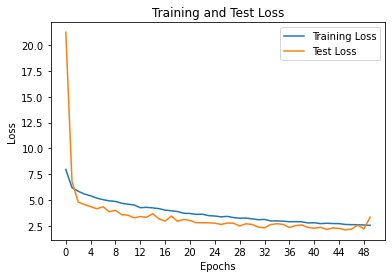

In [ ]:
# Load the training and validation loss dictionaries
train_loss = load(open('/content/drive/MyDrive/ML/train_loss_DenseNet121.pkl', 'rb'))
test_loss = load(open('/content/drive/MyDrive/ML/test_loss_DenseNet121.pkl', 'rb'))

# Retrieve each dictionary's values
train_values = train_loss.values()
test_values = test_loss.values()

# Generate a sequence of integers to represent the epoch numbers
epochs = range(50)

# Plot and label the training and validation loss values
plt.plot(epochs, np.array(list(train_values)).astype(float), label='Training Loss')
plt.plot(epochs, np.array(list(test_values)).astype(float), label='Test Loss')

# Add in a title and axes labels
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(arange(0, 50, 4))

# Display the plot
plt.legend(loc='best')
plt.show()

In [ ]:
#model save
dir = '/content/drive/MyDrive/Colab Notebooks/'
filename =os.path.join( dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "DenseNet121_simclr.h5")  ##set your path then model name: /content/resnet.h5
print(filename)

model.save_weights(filename)

/content/drive/MyDrive/Colab Notebooks/20230315-183737DenseNet121_simclr.h5


#Classifier with frozen Encoder

In [ ]:
new_model = get_resnet_simclr(512, 256, 128)
new_model.load_weights("/content/drive/MyDrive/Colab Notebooks/20230315-183737DenseNet121_simclr.h5")

In [ ]:
classifier_optimizer = tf.keras.optimizers.Adam(learning_rate=LR)

In [ ]:
def Classifier_Network():
    '''For stage 2, simply a softmax on top of the Encoder.
    '''
    contrast_model = new_model
    contrast_model.trainable = False
    embedd = contrast_model.output
    features = Dropout(0.5)(embedd)
    features = Dense(64, activation="relu")(features)
    features = Dropout(0.5)(features)
    outputs  = Dense(num_classes, activation="softmax")(features)

    classifier_model = Model(contrast_model.inputs, outputs)

    return classifier_model

In [ ]:
classifier = Classifier_Network()

In [ ]:
classifier.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_2[0][0]']       
                                )                                                           

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='train_ACC')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='test_ACC')

In [ ]:
cce_loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

In [ ]:
sample_weight = tf.random.uniform((tf.shape(y_train)[0], 1),
                                    minval=0,
                                    maxval=1,
                                    dtype=tf.float32)
sample_weight

<tf.Tensor: shape=(8529, 1), dtype=float32, numpy=
array([[0.7861433 ],
       [0.49920297],
       [0.29927063],
       ...,
       [0.05716491],
       [0.14451802],
       [0.6533736 ]], dtype=float32)>

In [ ]:
@tf.function
# train step for the 2nd stage
def train_step(x, y,sample_weight):
    '''
    x: data tensor, shape: (batch_size, data_dim)
    y: data labels, shape: (batch_size, )
    '''
    with tf.GradientTape() as tape:
        y_preds = classifier(x, training=True)
        loss = cce_loss_obj(y, y_preds,sample_weight = sample_weight)

    # freeze the encoder, only train the softmax layer
    gradients = tape.gradient(loss,
                              classifier.trainable_variables)
    classifier_optimizer.apply_gradients(zip(gradients,
                                  classifier.trainable_variables))

    train_loss(loss)
    train_acc(y, y_preds)

In [ ]:
@tf.function
def test_step(x, y):
    y_preds = classifier(x, training=False)
    t_loss = cce_loss_obj(y, y_preds)
    test_loss(t_loss)
    test_acc(y, y_preds)

In [ ]:
#classifier training
train_loss_dict_classifier = {}
test_loss_dict_classifier = {}
train_acc_dict = {}
test_acc_dict = {}

for epoch in range(220):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_acc.reset_states()
    test_loss.reset_states()
    test_acc.reset_states()


    for x, y in tqdm(train_ds2):
        #print(x.shape,y.shape)
        sample_weight = tf.random.uniform((tf.shape(x)[0], 1),
                                    minval=0,
                                    maxval=1,
                                    dtype=tf.float32)
        train_step(x, y,sample_weight)

    for x_te, y_te in test_ds:
        test_step(x_te, y_te)

    template = 'Epoch {}, Train Loss: {}, Train Acc: {}, Test Loss: {}, Test Acc: {}'
    print(template.format(epoch + 1,train_loss.result(), train_acc.result() * 100,test_loss.result(),test_acc.result() * 100))
    train_loss_dict_classifier[epoch] = train_loss.result().numpy()
    test_loss_dict_classifier[epoch] = test_loss.result().numpy()
    train_acc_dict[epoch] = train_acc.result().numpy()*100
    test_acc_dict[epoch] = test_acc.result().numpy()*100

100%|██████████| 134/134 [00:43<00:00,  3.05it/s]


Epoch 1, Train Loss: 1.5595629215240479, Train Acc: 5.4285383224487305, Test Loss: 3.1055657863616943, Test Acc: 3.844350576400757


100%|██████████| 134/134 [00:21<00:00,  6.29it/s]


Epoch 2, Train Loss: 1.5504393577575684, Train Acc: 6.69480562210083, Test Loss: 3.0773277282714844, Test Acc: 11.064228057861328


100%|██████████| 134/134 [00:21<00:00,  6.21it/s]


Epoch 3, Train Loss: 1.5358339548110962, Train Acc: 9.03974723815918, Test Loss: 3.0492441654205322, Test Acc: 25.457101821899414


100%|██████████| 134/134 [00:21<00:00,  6.14it/s]


Epoch 4, Train Loss: 1.5291242599487305, Train Acc: 12.510259628295898, Test Loss: 3.0202770233154297, Test Acc: 28.59821891784668


100%|██████████| 134/134 [00:22<00:00,  6.05it/s]


Epoch 5, Train Loss: 1.5014857053756714, Train Acc: 14.749677658081055, Test Loss: 2.991312026977539, Test Acc: 34.224098205566406


100%|██████████| 134/134 [00:22<00:00,  5.98it/s]


Epoch 6, Train Loss: 1.4904910326004028, Train Acc: 17.821550369262695, Test Loss: 2.96250319480896, Test Acc: 49.038909912109375


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 7, Train Loss: 1.4737735986709595, Train Acc: 20.506507873535156, Test Loss: 2.9284427165985107, Test Acc: 54.28973388671875


100%|██████████| 134/134 [00:22<00:00,  6.01it/s]


Epoch 8, Train Loss: 1.466088056564331, Train Acc: 23.94184684753418, Test Loss: 2.8967397212982178, Test Acc: 59.49367141723633


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 9, Train Loss: 1.442811369895935, Train Acc: 26.931644439697266, Test Loss: 2.860966682434082, Test Acc: 62.68166732788086


100%|██████████| 134/134 [00:22<00:00,  6.01it/s]


Epoch 10, Train Loss: 1.444472074508667, Train Acc: 30.413881301879883, Test Loss: 2.8242082595825195, Test Acc: 63.57242965698242


100%|██████████| 134/134 [00:22<00:00,  5.85it/s]


Epoch 11, Train Loss: 1.4035316705703735, Train Acc: 32.87607192993164, Test Loss: 2.787905216217041, Test Acc: 63.94749450683594


100%|██████████| 134/134 [00:22<00:00,  5.90it/s]


Epoch 12, Train Loss: 1.4010227918624878, Train Acc: 35.291358947753906, Test Loss: 2.7496204376220703, Test Acc: 64.041259765625


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 13, Train Loss: 1.3813992738723755, Train Acc: 36.99143981933594, Test Loss: 2.7077643871307373, Test Acc: 64.088134765625


100%|██████████| 134/134 [00:22<00:00,  5.95it/s]


Epoch 14, Train Loss: 1.3663820028305054, Train Acc: 39.723297119140625, Test Loss: 2.6695077419281006, Test Acc: 64.13501739501953


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 15, Train Loss: 1.3526805639266968, Train Acc: 39.781917572021484, Test Loss: 2.6233999729156494, Test Acc: 64.27567291259766


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 16, Train Loss: 1.3153656721115112, Train Acc: 41.822017669677734, Test Loss: 2.5835094451904297, Test Acc: 64.32254791259766


100%|██████████| 134/134 [00:22<00:00,  6.02it/s]


Epoch 17, Train Loss: 1.3073803186416626, Train Acc: 43.44002914428711, Test Loss: 2.5354537963867188, Test Acc: 64.46319580078125


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 18, Train Loss: 1.2839221954345703, Train Acc: 44.9759635925293, Test Loss: 2.496704578399658, Test Acc: 64.41631317138672


100%|██████████| 134/134 [00:22<00:00,  6.01it/s]


Epoch 19, Train Loss: 1.266493558883667, Train Acc: 46.73466873168945, Test Loss: 2.451143980026245, Test Acc: 64.32254791259766


100%|██████████| 134/134 [00:22<00:00,  5.93it/s]


Epoch 20, Train Loss: 1.2528148889541626, Train Acc: 47.238834381103516, Test Loss: 2.4073524475097656, Test Acc: 64.60384368896484


100%|██████████| 134/134 [00:22<00:00,  5.91it/s]


Epoch 21, Train Loss: 1.2148414850234985, Train Acc: 48.118186950683594, Test Loss: 2.3635494709014893, Test Acc: 64.79137420654297


100%|██████████| 134/134 [00:22<00:00,  5.89it/s]


Epoch 22, Train Loss: 1.21296226978302, Train Acc: 49.37273025512695, Test Loss: 2.320330858230591, Test Acc: 64.88513946533203


100%|██████████| 134/134 [00:22<00:00,  5.86it/s]


Epoch 23, Train Loss: 1.1984295845031738, Train Acc: 50.134830474853516, Test Loss: 2.2762398719787598, Test Acc: 65.0257797241211


100%|██████████| 134/134 [00:22<00:00,  5.83it/s]


Epoch 24, Train Loss: 1.1638152599334717, Train Acc: 51.16660690307617, Test Loss: 2.235502243041992, Test Acc: 65.26019287109375


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 25, Train Loss: 1.1470839977264404, Train Acc: 51.6824951171875, Test Loss: 2.1957130432128906, Test Acc: 65.30708312988281


100%|██████████| 134/134 [00:22<00:00,  5.95it/s]


Epoch 26, Train Loss: 1.112866997718811, Train Acc: 51.9404411315918, Test Loss: 2.153165340423584, Test Acc: 65.30708312988281


100%|██████████| 134/134 [00:22<00:00,  5.89it/s]


Epoch 27, Train Loss: 1.1228184700012207, Train Acc: 52.66736602783203, Test Loss: 2.1109957695007324, Test Acc: 65.68213653564453


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 28, Train Loss: 1.0889980792999268, Train Acc: 53.769493103027344, Test Loss: 2.069927930831909, Test Acc: 66.05719757080078


100%|██████████| 134/134 [00:22<00:00,  5.93it/s]


Epoch 29, Train Loss: 1.0769919157028198, Train Acc: 54.49642562866211, Test Loss: 2.034811019897461, Test Acc: 66.2916030883789


100%|██████████| 134/134 [00:22<00:00,  5.90it/s]


Epoch 30, Train Loss: 1.0643925666809082, Train Acc: 54.285377502441406, Test Loss: 2.004568576812744, Test Acc: 66.61978149414062


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 31, Train Loss: 1.0315619707107544, Train Acc: 54.68402099609375, Test Loss: 1.9632288217544556, Test Acc: 66.71354675292969


100%|██████████| 134/134 [00:22<00:00,  5.94it/s]


Epoch 32, Train Loss: 1.0360043048858643, Train Acc: 56.559974670410156, Test Loss: 1.9264158010482788, Test Acc: 67.0417251586914


100%|██████████| 134/134 [00:22<00:00,  5.90it/s]


Epoch 33, Train Loss: 1.0084878206253052, Train Acc: 56.2668571472168, Test Loss: 1.889617919921875, Test Acc: 67.41677856445312


100%|██████████| 134/134 [00:22<00:00,  5.88it/s]


Epoch 34, Train Loss: 0.9981597065925598, Train Acc: 56.75929260253906, Test Loss: 1.8552417755126953, Test Acc: 67.74495697021484


100%|██████████| 134/134 [00:22<00:00,  5.84it/s]


Epoch 35, Train Loss: 0.9877685904502869, Train Acc: 56.68894577026367, Test Loss: 1.825181484222412, Test Acc: 67.93248748779297


100%|██████████| 134/134 [00:23<00:00,  5.82it/s]


Epoch 36, Train Loss: 0.9731600284576416, Train Acc: 57.16965866088867, Test Loss: 1.7915925979614258, Test Acc: 68.44819641113281


100%|██████████| 134/134 [00:23<00:00,  5.80it/s]


Epoch 37, Train Loss: 0.9483043551445007, Train Acc: 58.471099853515625, Test Loss: 1.7668418884277344, Test Acc: 68.54196166992188


100%|██████████| 134/134 [00:23<00:00,  5.78it/s]


Epoch 38, Train Loss: 0.9458944201469421, Train Acc: 58.97526168823242, Test Loss: 1.7421770095825195, Test Acc: 68.87013244628906


100%|██████████| 134/134 [00:23<00:00,  5.77it/s]


Epoch 39, Train Loss: 0.9328380227088928, Train Acc: 59.807716369628906, Test Loss: 1.708014726638794, Test Acc: 69.05767059326172


100%|██████████| 134/134 [00:23<00:00,  5.77it/s]


Epoch 40, Train Loss: 0.9056428670883179, Train Acc: 59.807716369628906, Test Loss: 1.683523416519165, Test Acc: 69.33895874023438


100%|██████████| 134/134 [00:23<00:00,  5.76it/s]


Epoch 41, Train Loss: 0.9052965044975281, Train Acc: 59.690467834472656, Test Loss: 1.6450427770614624, Test Acc: 69.7140121459961


100%|██████████| 134/134 [00:23<00:00,  5.75it/s]


Epoch 42, Train Loss: 0.8911512494087219, Train Acc: 60.27670669555664, Test Loss: 1.6168012619018555, Test Acc: 70.08908081054688


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 43, Train Loss: 0.8882391452789307, Train Acc: 60.74569320678711, Test Loss: 1.5949645042419434, Test Acc: 70.27660369873047


100%|██████████| 134/134 [00:22<00:00,  5.92it/s]


Epoch 44, Train Loss: 0.8798125982284546, Train Acc: 61.60159683227539, Test Loss: 1.5709044933319092, Test Acc: 70.4641342163086


100%|██████████| 134/134 [00:22<00:00,  5.86it/s]


Epoch 45, Train Loss: 0.8629083037376404, Train Acc: 61.589866638183594, Test Loss: 1.5527780055999756, Test Acc: 70.60478210449219


100%|██████████| 134/134 [00:22<00:00,  5.83it/s]


Epoch 46, Train Loss: 0.8477101922035217, Train Acc: 62.058860778808594, Test Loss: 1.5253928899765015, Test Acc: 70.74542999267578


100%|██████████| 134/134 [00:23<00:00,  5.81it/s]


Epoch 47, Train Loss: 0.8349307775497437, Train Acc: 62.37542724609375, Test Loss: 1.49797523021698, Test Acc: 71.07360076904297


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 48, Train Loss: 0.8372710943222046, Train Acc: 63.102359771728516, Test Loss: 1.4740015268325806, Test Acc: 71.16736602783203


100%|██████████| 134/134 [00:22<00:00,  5.95it/s]


Epoch 49, Train Loss: 0.815101146697998, Train Acc: 62.4809455871582, Test Loss: 1.451915979385376, Test Acc: 71.49554443359375


100%|██████████| 134/134 [00:22<00:00,  5.89it/s]


Epoch 50, Train Loss: 0.805383563041687, Train Acc: 63.512718200683594, Test Loss: 1.4371600151062012, Test Acc: 71.7299575805664


100%|██████████| 134/134 [00:22<00:00,  5.85it/s]


Epoch 51, Train Loss: 0.8086880445480347, Train Acc: 63.102359771728516, Test Loss: 1.4061145782470703, Test Acc: 71.96437072753906


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 52, Train Loss: 0.7682155966758728, Train Acc: 64.33345031738281, Test Loss: 1.396215558052063, Test Acc: 72.15190124511719


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 53, Train Loss: 0.7720460295677185, Train Acc: 65.02520751953125, Test Loss: 1.3635715246200562, Test Acc: 72.33942413330078


100%|██████████| 134/134 [00:22<00:00,  5.98it/s]


Epoch 54, Train Loss: 0.7653679847717285, Train Acc: 64.9431381225586, Test Loss: 1.3498690128326416, Test Acc: 72.43318939208984


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 55, Train Loss: 0.7555468082427979, Train Acc: 65.68179321289062, Test Loss: 1.332767367362976, Test Acc: 72.43318939208984


100%|██████████| 134/134 [00:22<00:00,  6.00it/s]


Epoch 56, Train Loss: 0.7584804892539978, Train Acc: 65.3300552368164, Test Loss: 1.3145006895065308, Test Acc: 72.57383728027344


100%|██████████| 134/134 [00:22<00:00,  5.91it/s]


Epoch 57, Train Loss: 0.7410484552383423, Train Acc: 65.61144256591797, Test Loss: 1.300754427909851, Test Acc: 72.99578094482422


100%|██████████| 134/134 [00:22<00:00,  5.91it/s]


Epoch 58, Train Loss: 0.7407549023628235, Train Acc: 65.96318817138672, Test Loss: 1.2922067642211914, Test Acc: 73.32395935058594


100%|██████████| 134/134 [00:22<00:00,  5.87it/s]


Epoch 59, Train Loss: 0.7384216785430908, Train Acc: 65.6231689453125, Test Loss: 1.253528118133545, Test Acc: 73.464599609375


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 60, Train Loss: 0.7200877666473389, Train Acc: 66.64321899414062, Test Loss: 1.2492984533309937, Test Acc: 73.69901275634766


100%|██████████| 134/134 [00:22<00:00,  5.92it/s]


Epoch 61, Train Loss: 0.7082567811012268, Train Acc: 67.2646255493164, Test Loss: 1.234869122505188, Test Acc: 73.69901275634766


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 62, Train Loss: 0.7069103121757507, Train Acc: 67.04185485839844, Test Loss: 1.2099610567092896, Test Acc: 74.0740737915039


100%|██████████| 134/134 [00:22<00:00,  5.95it/s]


Epoch 63, Train Loss: 0.7035846710205078, Train Acc: 66.6314926147461, Test Loss: 1.190981149673462, Test Acc: 73.93342590332031


100%|██████████| 134/134 [00:22<00:00,  5.89it/s]


Epoch 64, Train Loss: 0.6913282871246338, Train Acc: 67.56947326660156, Test Loss: 1.1852153539657593, Test Acc: 74.12095642089844


100%|██████████| 134/134 [00:22<00:00,  5.89it/s]


Epoch 65, Train Loss: 0.6894019246101379, Train Acc: 67.05358123779297, Test Loss: 1.1731674671173096, Test Acc: 74.40225219726562


100%|██████████| 134/134 [00:22<00:00,  5.87it/s]


Epoch 66, Train Loss: 0.6680918335914612, Train Acc: 68.27294921875, Test Loss: 1.1485977172851562, Test Acc: 74.44913482666016


100%|██████████| 134/134 [00:22<00:00,  5.84it/s]


Epoch 67, Train Loss: 0.6648591160774231, Train Acc: 67.86258697509766, Test Loss: 1.1418368816375732, Test Acc: 74.54290008544922


100%|██████████| 134/134 [00:23<00:00,  5.80it/s]


Epoch 68, Train Loss: 0.6708089709281921, Train Acc: 68.36674499511719, Test Loss: 1.121561884880066, Test Acc: 74.68354797363281


100%|██████████| 134/134 [00:23<00:00,  5.79it/s]


Epoch 69, Train Loss: 0.6618307828903198, Train Acc: 67.89775848388672, Test Loss: 1.1221277713775635, Test Acc: 74.77731323242188


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 70, Train Loss: 0.6486573219299316, Train Acc: 68.83573913574219, Test Loss: 1.1087418794631958, Test Acc: 74.96483612060547


100%|██████████| 134/134 [00:22<00:00,  5.94it/s]


Epoch 71, Train Loss: 0.6412867307662964, Train Acc: 68.73021697998047, Test Loss: 1.0918850898742676, Test Acc: 75.01171875


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 72, Train Loss: 0.6465686559677124, Train Acc: 69.0350570678711, Test Loss: 1.080810546875, Test Acc: 75.10548400878906


100%|██████████| 134/134 [00:22<00:00,  5.94it/s]


Epoch 73, Train Loss: 0.6360683441162109, Train Acc: 68.76538848876953, Test Loss: 1.0638965368270874, Test Acc: 75.29301452636719


100%|██████████| 134/134 [00:22<00:00,  5.90it/s]


Epoch 74, Train Loss: 0.6289118528366089, Train Acc: 68.83573913574219, Test Loss: 1.0523767471313477, Test Acc: 75.43366241455078


100%|██████████| 134/134 [00:22<00:00,  5.89it/s]


Epoch 75, Train Loss: 0.6330123543739319, Train Acc: 69.50404357910156, Test Loss: 1.0395638942718506, Test Acc: 75.6211929321289


100%|██████████| 134/134 [00:22<00:00,  5.86it/s]


Epoch 76, Train Loss: 0.6257798075675964, Train Acc: 69.31644439697266, Test Loss: 1.043031930923462, Test Acc: 75.76183319091797


100%|██████████| 134/134 [00:23<00:00,  5.82it/s]


Epoch 77, Train Loss: 0.6061267852783203, Train Acc: 68.9998779296875, Test Loss: 1.0318584442138672, Test Acc: 75.76183319091797


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 78, Train Loss: 0.6082953214645386, Train Acc: 69.16402435302734, Test Loss: 1.0175563097000122, Test Acc: 75.80872344970703


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 79, Train Loss: 0.6025992631912231, Train Acc: 69.9495849609375, Test Loss: 1.015432357788086, Test Acc: 75.9024887084961


100%|██████████| 134/134 [00:22<00:00,  5.97it/s]


Epoch 80, Train Loss: 0.6038493514060974, Train Acc: 70.52409362792969, Test Loss: 0.9985566735267639, Test Acc: 75.80872344970703


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 81, Train Loss: 0.6048055291175842, Train Acc: 69.55094146728516, Test Loss: 0.9816113710403442, Test Acc: 75.9024887084961


100%|██████████| 134/134 [00:22<00:00,  6.00it/s]


Epoch 82, Train Loss: 0.6037160754203796, Train Acc: 70.17234802246094, Test Loss: 0.9926241636276245, Test Acc: 76.09001159667969


100%|██████████| 134/134 [00:22<00:00,  5.91it/s]


Epoch 83, Train Loss: 0.5888176560401917, Train Acc: 70.12545776367188, Test Loss: 0.978359580039978, Test Acc: 75.99624633789062


100%|██████████| 134/134 [00:22<00:00,  5.91it/s]


Epoch 84, Train Loss: 0.5728943943977356, Train Acc: 70.26615142822266, Test Loss: 0.9677369594573975, Test Acc: 76.04312896728516


100%|██████████| 134/134 [00:22<00:00,  5.88it/s]


Epoch 85, Train Loss: 0.5898043513298035, Train Acc: 70.19580078125, Test Loss: 0.9696642756462097, Test Acc: 76.27754211425781


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 86, Train Loss: 0.5818003416061401, Train Acc: 70.84066009521484, Test Loss: 0.9487665891647339, Test Acc: 76.60572052001953


100%|██████████| 134/134 [00:22<00:00,  5.93it/s]


Epoch 87, Train Loss: 0.5640069842338562, Train Acc: 71.12205505371094, Test Loss: 0.9476972222328186, Test Acc: 76.84013366699219


100%|██████████| 134/134 [00:22<00:00,  5.91it/s]


Epoch 88, Train Loss: 0.5760979652404785, Train Acc: 70.88755798339844, Test Loss: 0.9420655369758606, Test Acc: 76.84013366699219


100%|██████████| 134/134 [00:22<00:00,  5.87it/s]


Epoch 89, Train Loss: 0.5741719603538513, Train Acc: 70.89928436279297, Test Loss: 0.9201615452766418, Test Acc: 76.84013366699219


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 90, Train Loss: 0.5754640102386475, Train Acc: 70.31304931640625, Test Loss: 0.9202971458435059, Test Acc: 76.93389892578125


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 91, Train Loss: 0.5590851902961731, Train Acc: 71.28620147705078, Test Loss: 0.9117757081985474, Test Acc: 76.79325103759766


100%|██████████| 134/134 [00:22<00:00,  6.01it/s]


Epoch 92, Train Loss: 0.5595860481262207, Train Acc: 70.9110107421875, Test Loss: 0.9214777946472168, Test Acc: 76.65260314941406


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 93, Train Loss: 0.5562635064125061, Train Acc: 71.19239807128906, Test Loss: 0.9024339914321899, Test Acc: 76.6994857788086


100%|██████████| 134/134 [00:22<00:00,  6.01it/s]


Epoch 94, Train Loss: 0.54366534948349, Train Acc: 71.41517639160156, Test Loss: 0.8971261978149414, Test Acc: 76.79325103759766


100%|██████████| 134/134 [00:22<00:00,  5.93it/s]


Epoch 95, Train Loss: 0.550726592540741, Train Acc: 71.36827087402344, Test Loss: 0.887852132320404, Test Acc: 76.74636840820312


100%|██████████| 134/134 [00:22<00:00,  5.91it/s]


Epoch 96, Train Loss: 0.5419210195541382, Train Acc: 71.23929595947266, Test Loss: 0.884885311126709, Test Acc: 76.79325103759766


100%|██████████| 134/134 [00:22<00:00,  5.89it/s]


Epoch 97, Train Loss: 0.5337997674942017, Train Acc: 71.5793228149414, Test Loss: 0.8866382837295532, Test Acc: 76.93389892578125


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 98, Train Loss: 0.5315201878547668, Train Acc: 71.60276794433594, Test Loss: 0.8712821006774902, Test Acc: 76.98077392578125


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 99, Train Loss: 0.5308998823165894, Train Acc: 71.75518798828125, Test Loss: 0.867824912071228, Test Acc: 77.07454681396484


100%|██████████| 134/134 [00:22<00:00,  6.01it/s]


Epoch 100, Train Loss: 0.5323021411895752, Train Acc: 71.72001647949219, Test Loss: 0.8592573404312134, Test Acc: 77.07454681396484


100%|██████████| 134/134 [00:22<00:00,  5.93it/s]


Epoch 101, Train Loss: 0.530320405960083, Train Acc: 71.52069091796875, Test Loss: 0.860968291759491, Test Acc: 77.12142181396484


100%|██████████| 134/134 [00:22<00:00,  5.90it/s]


Epoch 102, Train Loss: 0.525352954864502, Train Acc: 72.38832092285156, Test Loss: 0.8547725081443787, Test Acc: 77.2151870727539


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 103, Train Loss: 0.524948000907898, Train Acc: 72.10692596435547, Test Loss: 0.8414764404296875, Test Acc: 77.2151870727539


100%|██████████| 134/134 [00:22<00:00,  5.95it/s]


Epoch 104, Train Loss: 0.5237500667572021, Train Acc: 72.16555786132812, Test Loss: 0.846933126449585, Test Acc: 77.2151870727539


100%|██████████| 134/134 [00:22<00:00,  5.90it/s]


Epoch 105, Train Loss: 0.5096731781959534, Train Acc: 72.43521881103516, Test Loss: 0.8342152833938599, Test Acc: 77.3558349609375


100%|██████████| 134/134 [00:22<00:00,  5.89it/s]


Epoch 106, Train Loss: 0.5091790556907654, Train Acc: 71.8724365234375, Test Loss: 0.8366996049880981, Test Acc: 77.30895233154297


100%|██████████| 134/134 [00:22<00:00,  5.86it/s]


Epoch 107, Train Loss: 0.516531765460968, Train Acc: 72.44694519042969, Test Loss: 0.8330926299095154, Test Acc: 77.3558349609375


100%|██████████| 134/134 [00:22<00:00,  5.83it/s]


Epoch 108, Train Loss: 0.5068042278289795, Train Acc: 72.51729583740234, Test Loss: 0.82769775390625, Test Acc: 77.44960021972656


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 109, Train Loss: 0.5014477372169495, Train Acc: 72.59937286376953, Test Loss: 0.8145182132720947, Test Acc: 77.4964828491211


100%|██████████| 134/134 [00:22<00:00,  5.97it/s]


Epoch 110, Train Loss: 0.5073492527008057, Train Acc: 72.47039794921875, Test Loss: 0.8152572512626648, Test Acc: 77.59024810791016


100%|██████████| 134/134 [00:22<00:00,  5.90it/s]


Epoch 111, Train Loss: 0.5037550926208496, Train Acc: 72.59937286376953, Test Loss: 0.8150865435600281, Test Acc: 77.59024810791016


100%|██████████| 134/134 [00:22<00:00,  5.86it/s]


Epoch 112, Train Loss: 0.5057074427604675, Train Acc: 73.00972747802734, Test Loss: 0.8065398931503296, Test Acc: 77.63713073730469


100%|██████████| 134/134 [00:22<00:00,  5.83it/s]


Epoch 113, Train Loss: 0.4857512414455414, Train Acc: 73.0331802368164, Test Loss: 0.8020979762077332, Test Acc: 77.68401336669922


100%|██████████| 134/134 [00:23<00:00,  5.81it/s]


Epoch 114, Train Loss: 0.4921629726886749, Train Acc: 73.20905303955078, Test Loss: 0.8032822608947754, Test Acc: 77.63713073730469


100%|██████████| 134/134 [00:23<00:00,  5.79it/s]


Epoch 115, Train Loss: 0.5079593062400818, Train Acc: 73.19732666015625, Test Loss: 0.792850136756897, Test Acc: 77.77777862548828


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 116, Train Loss: 0.49698081612586975, Train Acc: 72.81040954589844, Test Loss: 0.7883914113044739, Test Acc: 77.82466125488281


100%|██████████| 134/134 [00:22<00:00,  5.94it/s]


Epoch 117, Train Loss: 0.48735228180885315, Train Acc: 73.0331802368164, Test Loss: 0.7842528223991394, Test Acc: 77.77777862548828


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 118, Train Loss: 0.48319387435913086, Train Acc: 73.17387390136719, Test Loss: 0.7873857021331787, Test Acc: 77.77777862548828


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 119, Train Loss: 0.48878830671310425, Train Acc: 73.080078125, Test Loss: 0.7944310307502747, Test Acc: 77.9653091430664


100%|██████████| 134/134 [00:22<00:00,  6.01it/s]


Epoch 120, Train Loss: 0.48527801036834717, Train Acc: 73.40837097167969, Test Loss: 0.7741284966468811, Test Acc: 78.01219177246094


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 121, Train Loss: 0.478351891040802, Train Acc: 73.68976593017578, Test Loss: 0.7702727317810059, Test Acc: 78.05907440185547


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 122, Train Loss: 0.4816579222679138, Train Acc: 73.49044799804688, Test Loss: 0.7654524445533752, Test Acc: 77.9653091430664


100%|██████████| 134/134 [00:22<00:00,  6.05it/s]


Epoch 123, Train Loss: 0.484900563955307, Train Acc: 73.1269760131836, Test Loss: 0.7741317749023438, Test Acc: 78.01219177246094


100%|██████████| 134/134 [00:22<00:00,  5.95it/s]


Epoch 124, Train Loss: 0.47708457708358765, Train Acc: 73.8421859741211, Test Loss: 0.7627685070037842, Test Acc: 78.05907440185547


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 125, Train Loss: 0.4750632643699646, Train Acc: 73.7601089477539, Test Loss: 0.7655784487724304, Test Acc: 78.01219177246094


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 126, Train Loss: 0.4681713879108429, Train Acc: 73.15042877197266, Test Loss: 0.7581496834754944, Test Acc: 78.05907440185547


100%|██████████| 134/134 [00:22<00:00,  6.04it/s]


Epoch 127, Train Loss: 0.4753026068210602, Train Acc: 73.3262939453125, Test Loss: 0.7481871247291565, Test Acc: 78.05907440185547


100%|██████████| 134/134 [00:22<00:00,  5.94it/s]


Epoch 128, Train Loss: 0.46796920895576477, Train Acc: 74.38152313232422, Test Loss: 0.7481905817985535, Test Acc: 78.05907440185547


100%|██████████| 134/134 [00:22<00:00,  5.90it/s]


Epoch 129, Train Loss: 0.47637325525283813, Train Acc: 73.65459442138672, Test Loss: 0.7490142583847046, Test Acc: 78.01219177246094


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 130, Train Loss: 0.46607154607772827, Train Acc: 73.87735748291016, Test Loss: 0.7480496764183044, Test Acc: 77.9653091430664


100%|██████████| 134/134 [00:22<00:00,  5.96it/s]


Epoch 131, Train Loss: 0.4680600166320801, Train Acc: 73.63114166259766, Test Loss: 0.7450258731842041, Test Acc: 78.01219177246094


100%|██████████| 134/134 [00:22<00:00,  5.91it/s]


Epoch 132, Train Loss: 0.4629932940006256, Train Acc: 74.17047882080078, Test Loss: 0.7405205368995667, Test Acc: 77.9653091430664


100%|██████████| 134/134 [00:22<00:00,  5.89it/s]


Epoch 133, Train Loss: 0.46020153164863586, Train Acc: 74.14702606201172, Test Loss: 0.7341151237487793, Test Acc: 77.9653091430664


100%|██████████| 134/134 [00:22<00:00,  5.86it/s]


Epoch 134, Train Loss: 0.46309489011764526, Train Acc: 73.7952880859375, Test Loss: 0.7362892031669617, Test Acc: 78.10595703125


100%|██████████| 134/134 [00:22<00:00,  5.83it/s]


Epoch 135, Train Loss: 0.4580221176147461, Train Acc: 74.34634399414062, Test Loss: 0.7339471578598022, Test Acc: 78.10595703125


100%|██████████| 134/134 [00:23<00:00,  5.81it/s]


Epoch 136, Train Loss: 0.4486357867717743, Train Acc: 74.73326110839844, Test Loss: 0.7331355214118958, Test Acc: 78.10595703125


100%|██████████| 134/134 [00:23<00:00,  5.79it/s]


Epoch 137, Train Loss: 0.4560162127017975, Train Acc: 74.51049041748047, Test Loss: 0.7392457127571106, Test Acc: 78.29348754882812


100%|██████████| 134/134 [00:23<00:00,  5.77it/s]


Epoch 138, Train Loss: 0.4483136534690857, Train Acc: 74.28772735595703, Test Loss: 0.735742449760437, Test Acc: 78.34036254882812


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 139, Train Loss: 0.45941510796546936, Train Acc: 73.88908386230469, Test Loss: 0.7171907424926758, Test Acc: 78.24659729003906


100%|██████████| 134/134 [00:22<00:00,  5.92it/s]


Epoch 140, Train Loss: 0.4544929563999176, Train Acc: 74.81533813476562, Test Loss: 0.72870272397995, Test Acc: 78.05907440185547


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 141, Train Loss: 0.43984007835388184, Train Acc: 74.72154235839844, Test Loss: 0.7213900685310364, Test Acc: 78.05907440185547


100%|██████████| 134/134 [00:22<00:00,  5.92it/s]


Epoch 142, Train Loss: 0.4492037296295166, Train Acc: 74.59256744384766, Test Loss: 0.7144852876663208, Test Acc: 78.24659729003906


100%|██████████| 134/134 [00:22<00:00,  5.90it/s]


Epoch 143, Train Loss: 0.43594709038734436, Train Acc: 75.09672546386719, Test Loss: 0.7083852291107178, Test Acc: 78.24659729003906


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 144, Train Loss: 0.43750280141830444, Train Acc: 74.10012817382812, Test Loss: 0.7125997543334961, Test Acc: 78.29348754882812


100%|██████████| 134/134 [00:22<00:00,  5.94it/s]


Epoch 145, Train Loss: 0.44302257895469666, Train Acc: 74.42842102050781, Test Loss: 0.7111420035362244, Test Acc: 78.29348754882812


100%|██████████| 134/134 [00:22<00:00,  5.90it/s]


Epoch 146, Train Loss: 0.44316208362579346, Train Acc: 74.53394317626953, Test Loss: 0.71562260389328, Test Acc: 78.24659729003906


100%|██████████| 134/134 [00:22<00:00,  5.88it/s]


Epoch 147, Train Loss: 0.4348224699497223, Train Acc: 74.88568115234375, Test Loss: 0.7043152451515198, Test Acc: 78.34036254882812


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 148, Train Loss: 0.43682610988616943, Train Acc: 74.72154235839844, Test Loss: 0.7134561538696289, Test Acc: 78.29348754882812


100%|██████████| 134/134 [00:22<00:00,  5.92it/s]


Epoch 149, Train Loss: 0.43021881580352783, Train Acc: 75.1905288696289, Test Loss: 0.7058538198471069, Test Acc: 78.43412780761719


100%|██████████| 134/134 [00:22<00:00,  5.91it/s]


Epoch 150, Train Loss: 0.43626347184181213, Train Acc: 74.85050964355469, Test Loss: 0.6961919665336609, Test Acc: 78.34036254882812


100%|██████████| 134/134 [00:22<00:00,  5.87it/s]


Epoch 151, Train Loss: 0.4446363151073456, Train Acc: 74.5573959350586, Test Loss: 0.7017093300819397, Test Acc: 78.38724517822266


100%|██████████| 134/134 [00:22<00:00,  5.83it/s]


Epoch 152, Train Loss: 0.4313924014568329, Train Acc: 74.79188537597656, Test Loss: 0.6943236589431763, Test Acc: 78.38724517822266


100%|██████████| 134/134 [00:23<00:00,  5.81it/s]


Epoch 153, Train Loss: 0.43500304222106934, Train Acc: 75.10845184326172, Test Loss: 0.6901834011077881, Test Acc: 78.43412780761719


100%|██████████| 134/134 [00:23<00:00,  5.79it/s]


Epoch 154, Train Loss: 0.4305553138256073, Train Acc: 74.66291046142578, Test Loss: 0.7010919451713562, Test Acc: 78.48101043701172


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 155, Train Loss: 0.4288833439350128, Train Acc: 74.92086029052734, Test Loss: 0.6939370036125183, Test Acc: 78.52790069580078


100%|██████████| 134/134 [00:22<00:00,  5.93it/s]


Epoch 156, Train Loss: 0.42897361516952515, Train Acc: 75.33122253417969, Test Loss: 0.693903923034668, Test Acc: 78.52790069580078


100%|██████████| 134/134 [00:22<00:00,  5.88it/s]


Epoch 157, Train Loss: 0.4289221465587616, Train Acc: 75.46019744873047, Test Loss: 0.6859263181686401, Test Acc: 78.57477569580078


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 158, Train Loss: 0.4398649036884308, Train Acc: 75.0029296875, Test Loss: 0.6883382797241211, Test Acc: 78.57477569580078


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 159, Train Loss: 0.42808839678764343, Train Acc: 74.83879089355469, Test Loss: 0.6783254146575928, Test Acc: 78.57477569580078


100%|██████████| 134/134 [00:22<00:00,  5.99it/s]


Epoch 160, Train Loss: 0.43465209007263184, Train Acc: 74.9560317993164, Test Loss: 0.6841684579849243, Test Acc: 78.57477569580078


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 161, Train Loss: 0.43046241998672485, Train Acc: 75.81193542480469, Test Loss: 0.6893890500068665, Test Acc: 78.52790069580078


100%|██████████| 134/134 [00:22<00:00,  5.99it/s]


Epoch 162, Train Loss: 0.4171755611896515, Train Acc: 75.2843246459961, Test Loss: 0.6785389184951782, Test Acc: 78.62165832519531


100%|██████████| 134/134 [00:22<00:00,  5.92it/s]


Epoch 163, Train Loss: 0.4299754798412323, Train Acc: 75.87055969238281, Test Loss: 0.681637167930603, Test Acc: 78.57477569580078


100%|██████████| 134/134 [00:22<00:00,  5.91it/s]


Epoch 164, Train Loss: 0.42403072118759155, Train Acc: 75.70641326904297, Test Loss: 0.673419177532196, Test Acc: 78.57477569580078


100%|██████████| 134/134 [00:22<00:00,  5.88it/s]


Epoch 165, Train Loss: 0.4204441010951996, Train Acc: 74.90913391113281, Test Loss: 0.679781436920166, Test Acc: 78.66854095458984


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 166, Train Loss: 0.4211786985397339, Train Acc: 75.31949615478516, Test Loss: 0.6808667182922363, Test Acc: 78.66854095458984


100%|██████████| 134/134 [00:22<00:00,  5.95it/s]


Epoch 167, Train Loss: 0.4166496992111206, Train Acc: 74.90913391113281, Test Loss: 0.668976902961731, Test Acc: 78.57477569580078


100%|██████████| 134/134 [00:22<00:00,  5.89it/s]


Epoch 168, Train Loss: 0.4158343970775604, Train Acc: 75.37812042236328, Test Loss: 0.666550874710083, Test Acc: 78.57477569580078


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 169, Train Loss: 0.4105895459651947, Train Acc: 75.26087951660156, Test Loss: 0.671342670917511, Test Acc: 78.57477569580078


100%|██████████| 134/134 [00:22<00:00,  5.95it/s]


Epoch 170, Train Loss: 0.4156510829925537, Train Acc: 75.34294891357422, Test Loss: 0.6634626388549805, Test Acc: 78.57477569580078


100%|██████████| 134/134 [00:22<00:00,  5.89it/s]


Epoch 171, Train Loss: 0.4150494635105133, Train Acc: 76.01126098632812, Test Loss: 0.6614362597465515, Test Acc: 78.62165832519531


100%|██████████| 134/134 [00:22<00:00,  5.89it/s]


Epoch 172, Train Loss: 0.4149804711341858, Train Acc: 75.83538055419922, Test Loss: 0.6592416167259216, Test Acc: 78.62165832519531


100%|██████████| 134/134 [00:22<00:00,  5.83it/s]


Epoch 173, Train Loss: 0.415852814912796, Train Acc: 75.89401245117188, Test Loss: 0.6612507700920105, Test Acc: 78.62165832519531


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 174, Train Loss: 0.4188176989555359, Train Acc: 75.97608184814453, Test Loss: 0.6613984704017639, Test Acc: 78.62165832519531


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 175, Train Loss: 0.4144349992275238, Train Acc: 75.65951538085938, Test Loss: 0.656262993812561, Test Acc: 78.62165832519531


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 176, Train Loss: 0.4099310040473938, Train Acc: 76.12850189208984, Test Loss: 0.658126175403595, Test Acc: 78.66854095458984


100%|██████████| 134/134 [00:22<00:00,  6.03it/s]


Epoch 177, Train Loss: 0.41601845622062683, Train Acc: 76.12850189208984, Test Loss: 0.6578326225280762, Test Acc: 78.71542358398438


100%|██████████| 134/134 [00:22<00:00,  5.95it/s]


Epoch 178, Train Loss: 0.4009714722633362, Train Acc: 76.22229766845703, Test Loss: 0.6517885327339172, Test Acc: 78.7623062133789


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 179, Train Loss: 0.40916144847869873, Train Acc: 76.26919555664062, Test Loss: 0.6680141687393188, Test Acc: 78.71542358398438


100%|██████████| 134/134 [00:22<00:00,  5.98it/s]


Epoch 180, Train Loss: 0.40759751200675964, Train Acc: 75.89401245117188, Test Loss: 0.6504245400428772, Test Acc: 78.66854095458984


100%|██████████| 134/134 [00:22<00:00,  5.90it/s]


Epoch 181, Train Loss: 0.412100225687027, Train Acc: 75.83538055419922, Test Loss: 0.6592050194740295, Test Acc: 78.85607147216797


100%|██████████| 134/134 [00:22<00:00,  5.91it/s]


Epoch 182, Train Loss: 0.41243448853492737, Train Acc: 75.7650375366211, Test Loss: 0.6487002372741699, Test Acc: 78.80918884277344


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 183, Train Loss: 0.4074013829231262, Train Acc: 76.53886413574219, Test Loss: 0.6496567130088806, Test Acc: 78.80918884277344


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 184, Train Loss: 0.40759116411209106, Train Acc: 76.10504913330078, Test Loss: 0.6427753567695618, Test Acc: 78.80918884277344


100%|██████████| 134/134 [00:22<00:00,  6.01it/s]


Epoch 185, Train Loss: 0.4022287428379059, Train Acc: 76.25747680664062, Test Loss: 0.6427661776542664, Test Acc: 78.85607147216797


100%|██████████| 134/134 [00:22<00:00,  5.92it/s]


Epoch 186, Train Loss: 0.3966177999973297, Train Acc: 76.25747680664062, Test Loss: 0.6565206050872803, Test Acc: 78.80918884277344


100%|██████████| 134/134 [00:22<00:00,  5.90it/s]


Epoch 187, Train Loss: 0.3981989920139313, Train Acc: 76.60921478271484, Test Loss: 0.6448152661323547, Test Acc: 78.94983673095703


100%|██████████| 134/134 [00:22<00:00,  5.88it/s]


Epoch 188, Train Loss: 0.39872485399246216, Train Acc: 76.23402404785156, Test Loss: 0.6388680934906006, Test Acc: 78.9029541015625


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 189, Train Loss: 0.4065866470336914, Train Acc: 75.7650375366211, Test Loss: 0.6381891369819641, Test Acc: 79.0436019897461


100%|██████████| 134/134 [00:22<00:00,  5.93it/s]


Epoch 190, Train Loss: 0.3985545039176941, Train Acc: 76.16368103027344, Test Loss: 0.6377692222595215, Test Acc: 79.0436019897461


100%|██████████| 134/134 [00:22<00:00,  5.89it/s]


Epoch 191, Train Loss: 0.40440887212753296, Train Acc: 76.52714538574219, Test Loss: 0.6373926997184753, Test Acc: 79.0436019897461


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 192, Train Loss: 0.4057309627532959, Train Acc: 76.46852111816406, Test Loss: 0.6404038071632385, Test Acc: 78.99671936035156


100%|██████████| 134/134 [00:22<00:00,  5.95it/s]


Epoch 193, Train Loss: 0.39194053411483765, Train Acc: 76.9140625, Test Loss: 0.6310146450996399, Test Acc: 79.09048461914062


100%|██████████| 134/134 [00:22<00:00,  5.90it/s]


Epoch 194, Train Loss: 0.3988490402698517, Train Acc: 76.1988525390625, Test Loss: 0.6357830166816711, Test Acc: 79.13736724853516


100%|██████████| 134/134 [00:22<00:00,  5.88it/s]


Epoch 195, Train Loss: 0.38989678025245667, Train Acc: 76.46852111816406, Test Loss: 0.6404948234558105, Test Acc: 79.09048461914062


100%|██████████| 134/134 [00:22<00:00,  5.84it/s]


Epoch 196, Train Loss: 0.39968013763427734, Train Acc: 76.18712615966797, Test Loss: 0.6374239921569824, Test Acc: 79.13736724853516


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 197, Train Loss: 0.3936552405357361, Train Acc: 76.8906021118164, Test Loss: 0.6333640217781067, Test Acc: 79.09048461914062


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 198, Train Loss: 0.403807669878006, Train Acc: 76.35127258300781, Test Loss: 0.6272034049034119, Test Acc: 79.09048461914062


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 199, Train Loss: 0.39350634813308716, Train Acc: 76.36299896240234, Test Loss: 0.630180835723877, Test Acc: 79.09048461914062


100%|██████████| 134/134 [00:22<00:00,  6.03it/s]


Epoch 200, Train Loss: 0.39321571588516235, Train Acc: 76.6795654296875, Test Loss: 0.6355425119400024, Test Acc: 79.13736724853516


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 201, Train Loss: 0.39134612679481506, Train Acc: 76.445068359375, Test Loss: 0.6308854222297668, Test Acc: 79.18424987792969


100%|██████████| 134/134 [00:22<00:00,  6.02it/s]


Epoch 202, Train Loss: 0.3912075161933899, Train Acc: 76.56231689453125, Test Loss: 0.6315730810165405, Test Acc: 79.18424987792969


100%|██████████| 134/134 [00:22<00:00,  5.92it/s]


Epoch 203, Train Loss: 0.3955994248390198, Train Acc: 76.6326675415039, Test Loss: 0.6245698928833008, Test Acc: 79.32489776611328


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 204, Train Loss: 0.3964548110961914, Train Acc: 76.74991607666016, Test Loss: 0.6305553317070007, Test Acc: 79.27800750732422


100%|██████████| 134/134 [00:22<00:00,  5.98it/s]


Epoch 205, Train Loss: 0.38633301854133606, Train Acc: 76.7264633178711, Test Loss: 0.627761721611023, Test Acc: 79.27800750732422


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 206, Train Loss: 0.39656969904899597, Train Acc: 76.35127258300781, Test Loss: 0.6340653896331787, Test Acc: 79.32489776611328


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 207, Train Loss: 0.3947347104549408, Train Acc: 76.38644409179688, Test Loss: 0.6246562004089355, Test Acc: 79.32489776611328


100%|██████████| 134/134 [00:22<00:00,  6.03it/s]


Epoch 208, Train Loss: 0.38381925225257874, Train Acc: 77.1250991821289, Test Loss: 0.6203846335411072, Test Acc: 79.46554565429688


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 209, Train Loss: 0.3977605104446411, Train Acc: 76.71473693847656, Test Loss: 0.6289191246032715, Test Acc: 79.46554565429688


100%|██████████| 134/134 [00:22<00:00,  6.02it/s]


Epoch 210, Train Loss: 0.3797750473022461, Train Acc: 76.62094116210938, Test Loss: 0.6137771606445312, Test Acc: 79.46554565429688


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 211, Train Loss: 0.385013222694397, Train Acc: 76.53886413574219, Test Loss: 0.6209652423858643, Test Acc: 79.46554565429688


100%|██████████| 134/134 [00:22<00:00,  6.03it/s]


Epoch 212, Train Loss: 0.3863062560558319, Train Acc: 77.07820892333984, Test Loss: 0.6154980063438416, Test Acc: 79.46554565429688


100%|██████████| 134/134 [00:22<00:00,  5.94it/s]


Epoch 213, Train Loss: 0.38080400228500366, Train Acc: 76.57403564453125, Test Loss: 0.6167834401130676, Test Acc: 79.46554565429688


100%|██████████| 134/134 [00:22<00:00,  5.91it/s]


Epoch 214, Train Loss: 0.3806702792644501, Train Acc: 76.84371185302734, Test Loss: 0.6221200227737427, Test Acc: 79.51242065429688


100%|██████████| 134/134 [00:22<00:00,  5.91it/s]


Epoch 215, Train Loss: 0.3848625719547272, Train Acc: 76.65611267089844, Test Loss: 0.6136150360107422, Test Acc: 79.51242065429688


100%|██████████| 134/134 [00:22<00:00,  5.87it/s]


Epoch 216, Train Loss: 0.38582444190979004, Train Acc: 76.60921478271484, Test Loss: 0.6200973391532898, Test Acc: 79.55931091308594


100%|██████████| 134/134 [00:22<00:00,  5.83it/s]


Epoch 217, Train Loss: 0.38496023416519165, Train Acc: 77.14855194091797, Test Loss: 0.6119468808174133, Test Acc: 79.60618591308594


100%|██████████| 134/134 [00:23<00:00,  5.80it/s]


Epoch 218, Train Loss: 0.37466132640838623, Train Acc: 76.8788833618164, Test Loss: 0.6170676350593567, Test Acc: 79.60618591308594


100%|██████████| 134/134 [00:23<00:00,  5.78it/s]


Epoch 219, Train Loss: 0.3792438507080078, Train Acc: 77.07820892333984, Test Loss: 0.6145005226135254, Test Acc: 79.60618591308594


100%|██████████| 134/134 [00:23<00:00,  5.77it/s]


Epoch 220, Train Loss: 0.3909352421760559, Train Acc: 76.86715698242188, Test Loss: 0.6095526218414307, Test Acc: 79.60618591308594


In [ ]:

# Save the training loss values
with open('/content/drive/MyDrive/ML/train_loss_2_DenseNet121.pkl', 'wb') as file:
    dump(train_loss_dict_classifier, file)

# Save the test loss values
with open('/content/drive/MyDrive/ML/test_loss_2_DenseNet121.pkl', 'wb') as file:
    dump(test_loss_dict_classifier, file)

# Save the training acc values
with open('/content/drive/MyDrive/ML/train_acc_2_DenseNet121.pkl', 'wb') as file:
    dump(train_acc_dict, file)

# Save the test acc values
with open('/content/drive/MyDrive/ML/test_acc_2_DenseNet121.pkl', 'wb') as file:
    dump(test_acc_dict, file)

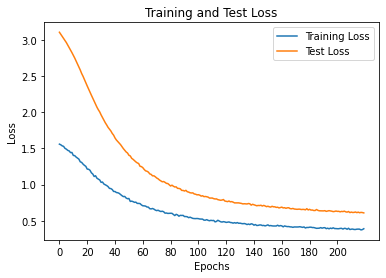

In [ ]:
# Load the training and validation loss dictionaries
train_loss_class = load(open('/content/drive/MyDrive/ML/train_loss_2_DenseNet121.pkl', 'rb'))
test_loss_class = load(open('/content/drive/MyDrive/ML/test_loss_2_DenseNet121.pkl', 'rb'))

# Retrieve each dictionary's values
train_values_class = train_loss_class.values()
test_values_class = test_loss_class.values()

# Generate a sequence of integers to represent the epoch numbers
epochs = range(220)

# Plot and label the training and validation loss values
plt.plot(epochs, np.array(list(train_values_class)).astype(float), label='Training Loss')
plt.plot(epochs, np.array(list(test_values_class)).astype(float), label='Test Loss')

# Add in a title and axes labels
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(arange(0, 220, 20))

# Display the plot
plt.legend(loc='best')
plt.show()

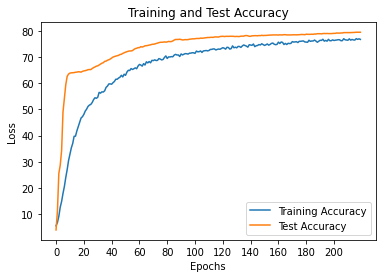

In [ ]:
# Load the training and validation loss dictionaries
train_acc = load(open('/content/drive/MyDrive/ML/train_acc_2_DenseNet121.pkl', 'rb'))
test_acc = load(open('/content/drive/MyDrive/ML/test_acc_2_DenseNet121.pkl', 'rb'))

# Retrieve each dictionary's values
train_values = train_acc.values()
test_values = test_acc.values()

# Generate a sequence of integers to represent the epoch numbers
epochs = range(220)

# Plot and label the training and validation loss values
plt.plot(epochs, np.array(list(train_values)).astype(float), label='Training Accuracy')
plt.plot(epochs, np.array(list(test_values)).astype(float), label='Test Accuracy')

# Add in a title and axes labels
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(arange(0, 220, 20))

# Display the plot
plt.legend(loc='best')
plt.show()

In [ ]:
#model save
dir = '/content/drive/MyDrive/Colab Notebooks/'
filenames =os.path.join( dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "DenseNet121_accuracy_simclr.h5")  ##set your path then model name: /content/resnet.h5
print(filenames)

classifier.save_weights(filenames)

/content/drive/MyDrive/Colab Notebooks/20230322-044545DenseNet121_accuracy_simclr.h5


##Prediction

In [ ]:
classifier.load_weights(filenames)

In [ ]:
X = tf.reshape(x_test[50], [1, 224, 224, 3]) ##need to reshape
classifier.predict(X)

1/1 [==============================] - 4s 4s/step


array([[4.34702146e-04, 1.11600726e-04, 4.92880412e-04, 1.06567364e-04,
        4.93522442e-04, 4.67607402e-04, 1.60498952e-03, 1.69497958e-04,
        3.93040059e-03, 4.18913405e-04, 4.21170704e-03, 5.28147519e-02,
        8.61865640e-01, 6.40988275e-02, 7.19811767e-04, 1.69536704e-03,
        2.04442840e-04, 1.50673976e-03, 3.83099366e-04, 3.28261522e-04,
        3.50259477e-04, 6.90745190e-04, 2.89968122e-03]], dtype=float32)

In [ ]:
y_predict = np.argmax(classifier.predict(x_test), axis=-1)
y_predict

67/67 [==============================] - 7s 77ms/step


array([18, 17, 11, ..., 16, 17, 11])

In [ ]:
#CONFUSIN MATRIX
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

In [ ]:
class_names = ["cecum", "ileum", "retroflex_rectum", "hemorrhoids", "polyps","ulcerative_colitis_grade_0_1","ulcerative_colitis_grade_1","ulcerative_colitis_grade_1_2","ulcerative_colitis_grade_2","ulcerative_colitis_grade_2_3","ulcerative_colitis_grade_3","bbps_0_1" ,"bbps_2_3","impacted_stool","dyed_lifted_polyps","dyed_resection_margins","pylorus","retroflex_stomach","z_line","barretts","barretts_short_segment","esophagitis_a" ,"esophagitis_b_d"]
print(metrics.classification_report(y_test, y_predict, target_names=class_names))

                              precision    recall  f1-score   support

                       cecum       0.91      0.98      0.94       202
                       ileum       0.00      0.00      0.00         2
            retroflex_rectum       0.69      0.69      0.69        78
                 hemorrhoids       0.00      0.00      0.00         1
                      polyps       1.00      0.99      1.00       206
ulcerative_colitis_grade_0_1       0.00      0.00      0.00         7
  ulcerative_colitis_grade_1       0.00      0.00      0.00        40
ulcerative_colitis_grade_1_2       0.00      0.00      0.00         2
  ulcerative_colitis_grade_2       0.58      0.69      0.63        89
ulcerative_colitis_grade_2_3       0.00      0.00      0.00         5
  ulcerative_colitis_grade_3       0.00      0.00      0.00        27
                    bbps_0_1       0.90      0.95      0.92       129
                    bbps_2_3       0.93      1.00      0.96       230
              impac

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


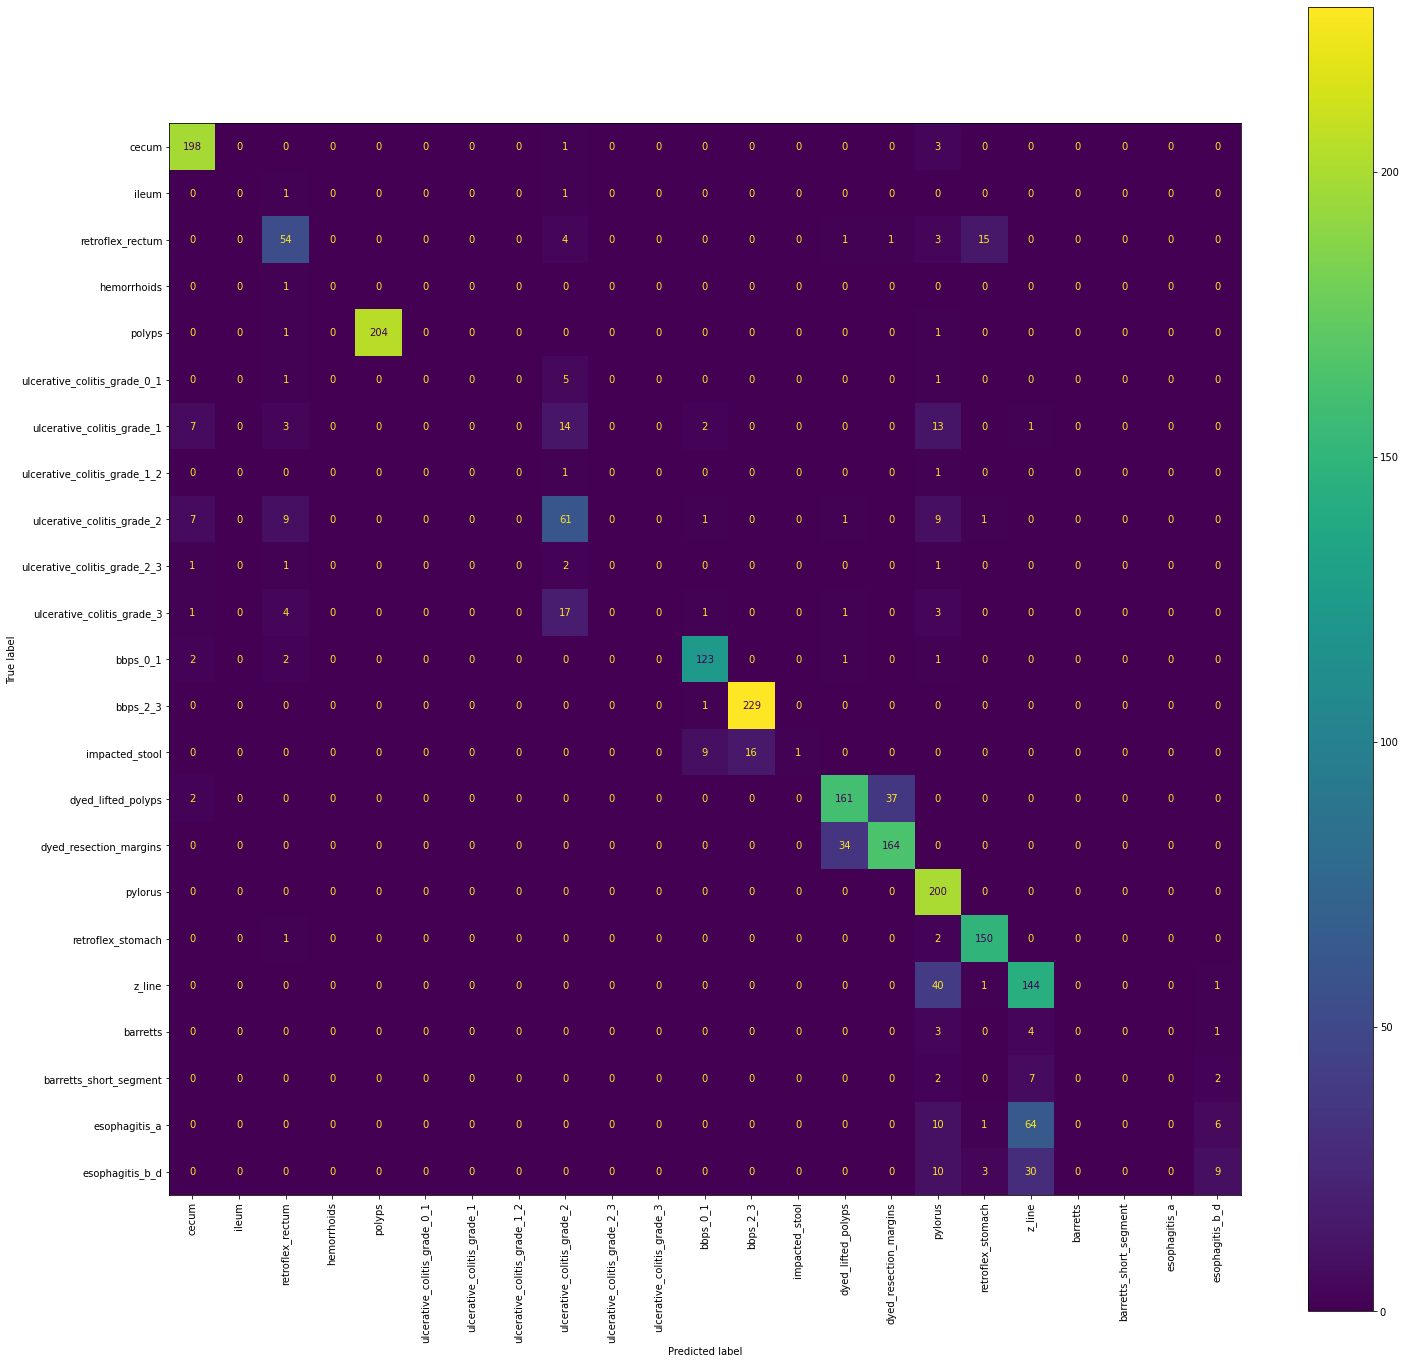

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test, y_predict)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,display_labels = class_names)

plt.rcParams["figure.figsize"] = [24,24]
cm_display.plot(xticks_rotation = 'vertical')
plt.show()

In [ ]:
#check layers trainable
for i, layer in enumerate(classifier.layers):
    print(i, layer.name, layer.output_shape, layer.trainable)

0 input_2 [(None, 224, 224, 3)] False
1 zero_padding2d_2 (None, 230, 230, 3) False
2 conv1/conv (None, 112, 112, 64) False
3 conv1/bn (None, 112, 112, 64) False
4 conv1/relu (None, 112, 112, 64) False
5 zero_padding2d_3 (None, 114, 114, 64) False
6 pool1 (None, 56, 56, 64) False
7 conv2_block1_0_bn (None, 56, 56, 64) False
8 conv2_block1_0_relu (None, 56, 56, 64) False
9 conv2_block1_1_conv (None, 56, 56, 128) False
10 conv2_block1_1_bn (None, 56, 56, 128) False
11 conv2_block1_1_relu (None, 56, 56, 128) False
12 conv2_block1_2_conv (None, 56, 56, 32) False
13 conv2_block1_concat (None, 56, 56, 96) False
14 conv2_block2_0_bn (None, 56, 56, 96) False
15 conv2_block2_0_relu (None, 56, 56, 96) False
16 conv2_block2_1_conv (None, 56, 56, 128) False
17 conv2_block2_1_bn (None, 56, 56, 128) False
18 conv2_block2_1_relu (None, 56, 56, 128) False
19 conv2_block2_2_conv (None, 56, 56, 32) False
20 conv2_block2_concat (None, 56, 56, 128) False
21 conv2_block3_0_bn (None, 56, 56, 128) False
22 co

#XAI

In [ ]:
##check if any error occurs here, if occurs, most likely graph not connected
def flatten_model(model):
    if not any(hasattr(layer, 'layers') for layer in model.layers):
        return model  # No sub-model defined within this model
    inputs = None
    outputs = None
    for layer in model.layers:
        if inputs is None:
            inputs = layer.input
        if hasattr(layer, 'layers'):
            submodel = layer
            last_layer = submodel.layers[-1]
            outputs = submodel.output

        if outputs is None:
            outputs = layer
        else:
            outputs = layer(outputs)
    return keras.Model(inputs=inputs, outputs=outputs)

flat_model = flatten_model(classifier)

In [ ]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

replace2linear = ReplaceToLinear()
X = tf.convert_to_tensor(x_test[50], dtype=tf.float32)    ##need to convert the input data to tensor
y = y_test[50].item()   ##just a single integer value, no numpy array
score = CategoricalScore(y)

In [ ]:
image_titles = ['Image']
from matplotlib import cm

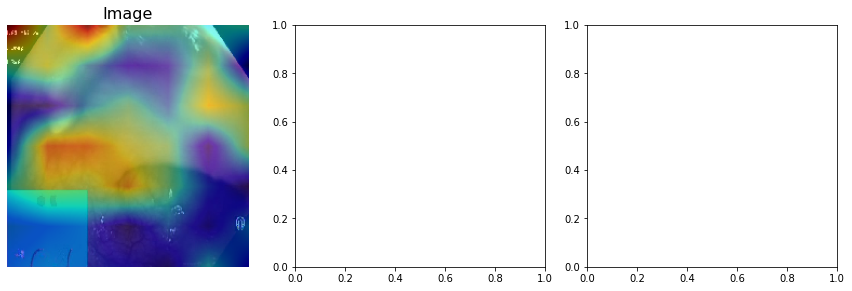

In [ ]:
from tf_keras_vis.gradcam import Gradcam

gradcam = Gradcam(classifier,
                  model_modifier=replace2linear,
                  clone=False)

grad_cam = gradcam(score, X, penultimate_layer=-1)
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap1 = np.uint8(cm.jet(grad_cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(x_test[50])
    ax[i].imshow(heatmap1, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

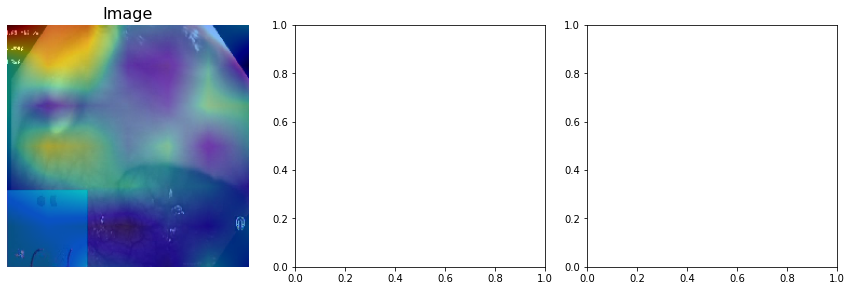

In [ ]:
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus

# Create GradCAM++ object
gradcam = GradcamPlusPlus(classifier, model_modifier=replace2linear,clone=False)

# Generate heatmap with GradCAM++
grad_cam = gradcam(score, X, penultimate_layer=-1)
# Render
#for i, title in enumerate(image_titles):
#    heatmap2 = np.uint8(cm.jet(grad_cam[i])[..., :3] * 255)
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap2 = np.uint8(cm.jet(grad_cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(x_test[50])
    ax[i].imshow(heatmap2, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

1/1 [==============================] - 2s 2s/step


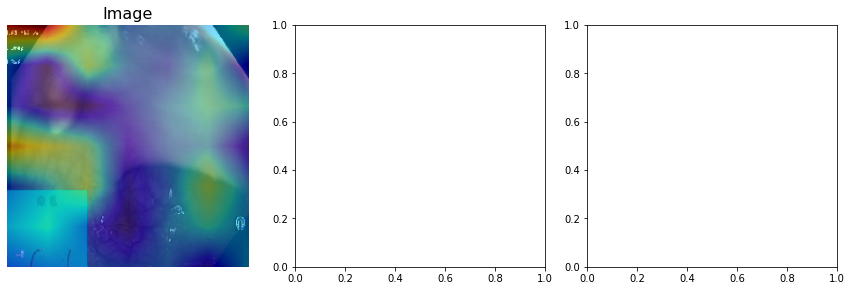

In [ ]:
from tf_keras_vis.scorecam import Scorecam
from tf_keras_vis.utils import num_of_gpus

# Create ScoreCAM object
scorecam = Scorecam(classifier)

# Generate heatmap with ScoreCAM
grad_cam = scorecam(score, X, penultimate_layer=-1, max_N=-1)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap3 = np.uint8(cm.jet(grad_cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(x_test[50])
    ax[i].imshow(heatmap3, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

1/1 [==============================] - 4s 4s/step


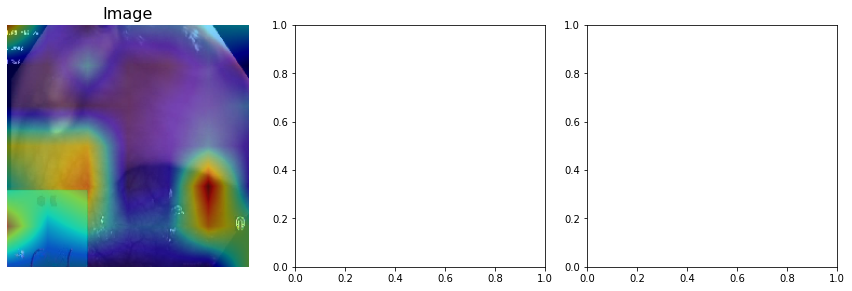

In [ ]:
# Create ScoreCAM object
scorecam = Scorecam(classifier)

# Generate heatmap with Faster-ScoreCAM
grad_cam = scorecam(score,X,penultimate_layer=-1,max_N=10)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap4 = np.uint8(cm.jet(grad_cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(x_test[50])
    ax[i].imshow(heatmap4, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

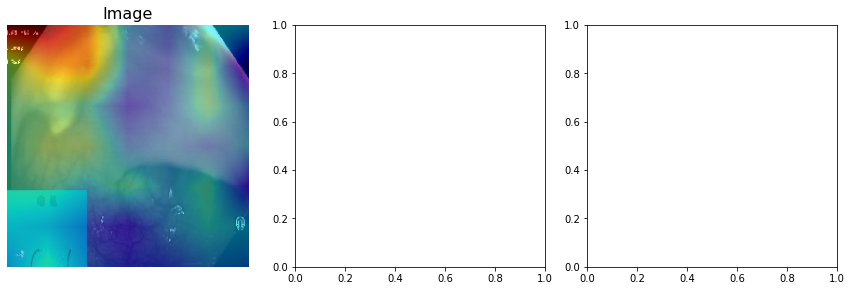

In [ ]:
from tf_keras_vis.layercam import Layercam

layercam = Layercam(classifier, model_modifier=replace2linear,clone = False)

# Generate heatmap with Faster-ScoreCAM
grad_cam = layercam(score,X,penultimate_layer=-1)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap5 = np.uint8(cm.jet(grad_cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(x_test[50])
    ax[i].imshow(heatmap5, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

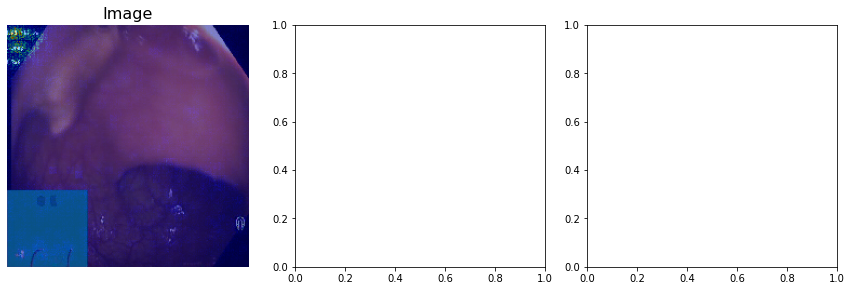

In [ ]:
from tf_keras_vis.saliency import Saliency

saliency = Saliency(classifier, model_modifier=replace2linear,clone=False)

# Generate saliency map
saliency_map_van = saliency(score, X)
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap6 = np.uint8(cm.jet(saliency_map_van[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(x_test[50])
    ax[i].imshow(heatmap6, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

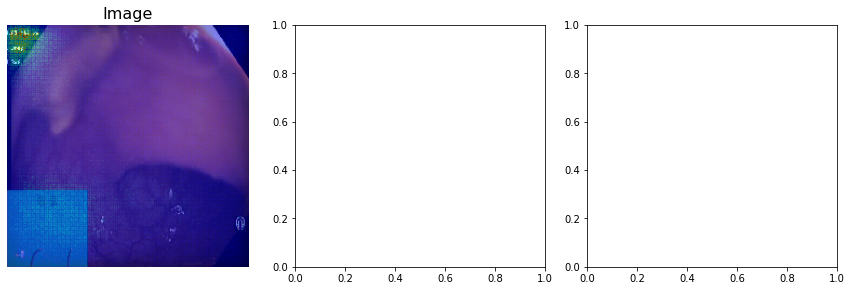

In [ ]:
# Generate saliency map with smoothing that reduce noise by adding noise
saliency_map_smooth = saliency(score,X,
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20) # noise spread level.
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap7 = np.uint8(cm.jet(saliency_map_smooth[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(x_test[50])
    ax[i].imshow(heatmap7, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

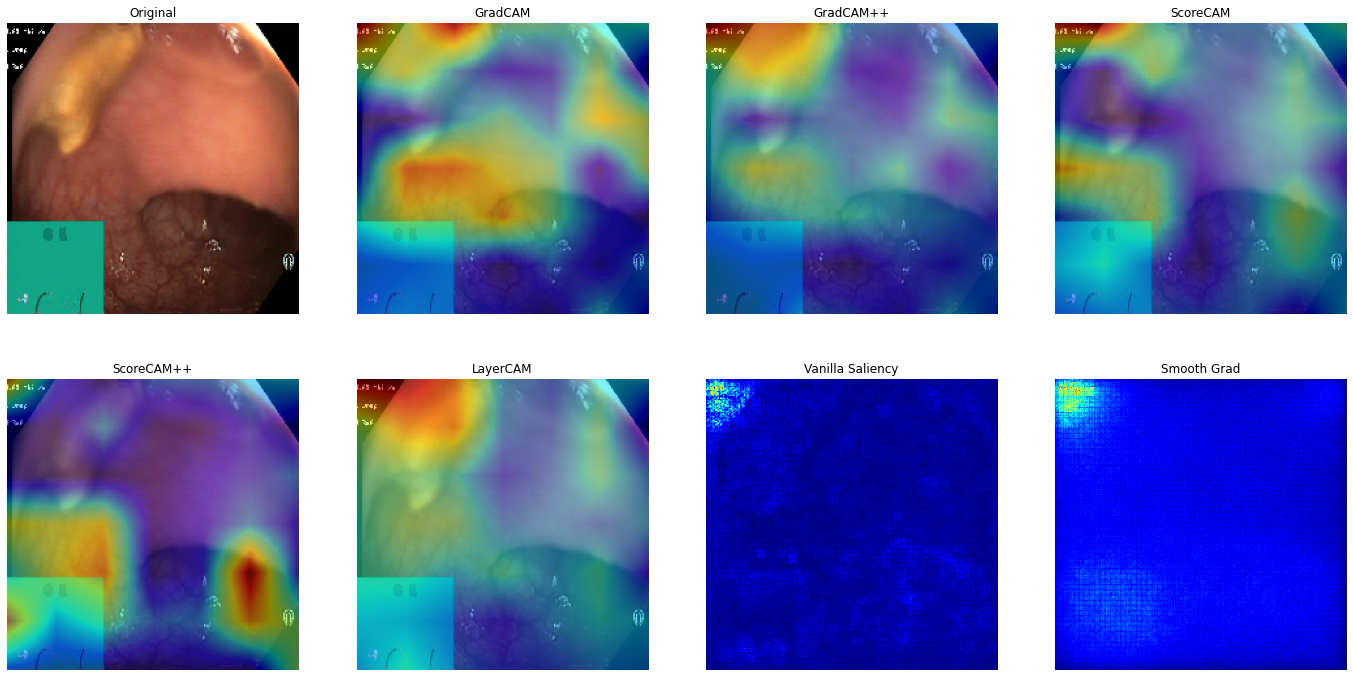

In [ ]:
# Render
f, ax = plt.subplots(nrows=2, ncols=4, figsize=(24, 12))

ax[0][0].set_title("Original", fontsize=12)
ax[0][0].imshow(x_test[50])
ax[0][0].axis('off')

ax[0][1].set_title("GradCAM", fontsize=12)
ax[0][1].imshow(x_test[50])
ax[0][1].imshow(heatmap1, cmap='jet', alpha=0.5)
ax[0][1].axis('off')

ax[0][2].set_title("GradCAM++", fontsize=12)
ax[0][2].imshow(x_test[50])
ax[0][2].imshow(heatmap2, cmap='jet', alpha=0.5)
ax[0][2].axis('off')

ax[0][3].set_title("ScoreCAM", fontsize=12)
ax[0][3].imshow(x_test[50])
ax[0][3].imshow(heatmap3, cmap='jet', alpha=0.5)
ax[0][3].axis('off')

ax[1][0].set_title("ScoreCAM++", fontsize=12)
ax[1][0].imshow(x_test[50])
ax[1][0].imshow(heatmap4, cmap='jet', alpha=0.5)
ax[1][0].axis('off')

ax[1][1].set_title("LayerCAM", fontsize=12)
ax[1][1].imshow(x_test[50])
ax[1][1].imshow(heatmap5, cmap='jet', alpha=0.5)
ax[1][1].axis('off')

ax[1][2].set_title("Vanilla Saliency", fontsize=12)
ax[1][2].imshow(saliency_map_van[0], cmap='jet')
ax[1][2].axis('off')

ax[1][3].set_title("Smooth Grad", fontsize=12)
ax[1][3].imshow(saliency_map_smooth[0], cmap='jet')
ax[1][3].axis('off')

plt.show()